In [1]:
import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
from __init__jupyterlab import *
from scipy import sparse
import collections
import itertools
import re
import fbpca
import pickle
import scipy.cluster.hierarchy as sch
from sklearn.metrics import euclidean_distances

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import seaborn as sns 
import matplotlib.pyplot as plt

# Configs  

In [2]:
config_dir = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons/' 
config_f = 'config_scf_8mods_data_freeze_190917.py' 

sys.path.insert(0, config_dir)
exec("from {} import *".format(config_f.split('.')[0]))
second_round_summary_results = os.path.join(outdir, 'intg_summary-{}-2-round-clustering.tsv'.format(name))
output_summary_results = os.path.join(outdir, 'intg_summary-{}-3-round-clustering.tsv'.format(name))
print(output_summary_results)

# name = 'mop_8mods_debug_0915'

# outdir = '/cndd/fangming/CEMBA/data/MOp_all/results'
# output_pcX_all = outdir + '/pcX_all_{}.npy'.format(name)
# output_cells_all = outdir + '/cells_all_{}.npy'.format(name)
# output_imputed_data_format = outdir + '/imputed_data_{}_{{}}.npy'.format(name)
# output_clst_and_umap = outdir + '/intg_summary_{}.tsv'.format(name)
# output_figures = outdir + '/figures/{}_{{}}.{{}}'.format(name)
# output_cluster_centroids = outdir + '/centroids_{}.pkl'.format(name)


/cndd/fangming/CEMBA/data/MOp_all/results/intg_summary-mop_8mods_0915_k30-3-round-clustering.tsv


In [3]:
# fixed dataset configs
sys.path.insert(0, DATA_DIR)
import __init__datasets
importlib.reload(__init__datasets)
from __init__datasets import *

meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
hvftrs_f = os.path.join(DATA_DIR, '{0}_hvfeatures.{1}')
hvftrs_gene = os.path.join(DATA_DIR, '{0}_hvfeatures.gene')
hvftrs_cell = os.path.join(DATA_DIR, '{0}_hvfeatures.cell')

## Read in data 

In [4]:
log = snmcseq_utils.create_logger()
logging.info('*')

10/07/2019 08:01:50 PM *


In [5]:
metas = collections.OrderedDict()
for mod in mods_selected:
    metas[mod] = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)
    print(mod, metas[mod].shape, len(np.unique(metas[mod][settings[mod].cluster_col])))

snmcseq_gene (9366, 32) 36
snatac_gene (54844, 13) 26


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


smarter_cells (6244, 129) 57
smarter_nuclei (5911, 146) 40
10x_cells_v2 (121440, 8) 80
10x_cells_v3 (69727, 8) 68
10x_nuclei_v3 (39706, 8) 61
10x_nuclei_v3_macosko (101647, 19) 76


## All done, making plots after 

- Plotting packages

In [6]:
# get results summary
mods_ordered = [
    'snatac_gene',
    'snmcseq_gene',
    'smarter_nuclei',
    'smarter_cells',
    '10x_cells_v3',
    '10x_nuclei_v3',
    '10x_nuclei_v3_macosko',
    '10x_cells_v2', 
    ]
assert set(mods_ordered) == set(mods_selected)

f = second_round_summary_results

df_info = pd.read_csv(f, sep="\t", index_col='sample') 
cluster_col_round_2 = 'cluster_round_2'
df_info['cluster_round_3'] = np.nan

main_clusters = df_info[cluster_col_round_2].unique()
n_clsts_round_2 = len(main_clusters)
print(main_clusters)

df_info_sub = []
for main_cluster in main_clusters:
#     f = '/cndd/fangming/CEMBA/data/MOp_all/results/intg_summary_mop_3mods_debug_0915_sub{}.tsv'.format(main_cluster)
    f = os.path.join(outdir, 'intg_summary_{}_sub{}.tsv'.format(name, main_cluster))
    df = pd.read_csv(f, sep='\t')
    df_modify = (df.filter(regex='^cluster', axis=1)
                   .applymap(lambda x: "{}-{}".format(main_cluster, x))
                )
    df.update(df_modify)
    df_info_sub.append(df)
df_info_sub = pd.concat(df_info_sub).set_index('sample').rename(columns={'cluster_joint_r0.1': 'cluster_round_3'})
df_info.update(df_info_sub[['cluster_round_3']])
                                         
print(df_info.shape)
print(len(df_info['cluster_round_2'].unique()))
print(len(df_info['cluster_round_3'].unique()))
print(len(df_info['cluster_joint_r0.1'].unique()))
print(len(df_info['cluster_joint_r1'].unique()))
df_info.head()

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['1-1' '4-2' '4-1' '6-2' '1-2' '6-4' '3-1' '3-2' '5-3' '2-1' '7-2' '7-1'
 '9-2' '6-5' '6-1' '5-4' '5-2' '5-1' '2-2' '2-3' '6-6' '6-3' '3-3' '9-1'
 '10-1' '5-5' '8-2' '8-3' '8-1']
(408885, 14)
29
56
10
26


cluster_joint_r0.1  cluster_joint_r1  \
sample                                                         
snmcseq_gene_2C_M_0                      1                11   
snmcseq_gene_2C_M_1                      4                 1   
snmcseq_gene_2C_M_100                    4                 1   
snmcseq_gene_2C_M_1000                   4                 1   
snmcseq_gene_2C_M_1001                   4                 1   

                        cluster_joint_r2  cluster_joint_r4  tsne_x_joint  \
sample                                                                     
snmcseq_gene_2C_M_0                   10                23      0.471629   
snmcseq_gene_2C_M_1                    8                 4     -2.414973   
snmcseq_gene_2C_M_100                  8                49     -1.446751   
snmcseq_gene_2C_M_1000                 8                49     -1.901734   
snmcseq_gene_2C_M_1001                 8                10     -0.981086   

                        tsne_y_joint      modality    modality_name  \
sample                                                                
snmcseq_gene_2C_M_0        -3.134735  snmcseq_gene  DNA methylation   
snmcseq_gene_2C_M_1       -12.098081  snmcseq_gene  DNA methylation   
snmcseq_gene_2C_M_100     -12.051894  snmcseq_gene  DNA methylation   
snmcseq_gene_2C_M_1000    -13.660591  snmcseq_gene  DNA methylation   
snmcseq_gene_2C_M_1001    -11.936621  snmcseq_gene  DNA methylation   

                                      cluster                  annot  \
sample                                                                 
snmcseq_gene_2C_M_0     L4-IT-Rorb_Rorb-Tenm2  L4-IT-Rorb_Rorb-Tenm2   
snmcseq_gene_2C_M_1               L23-IT-Cux2            L23-IT-Cux2   
snmcseq_gene_2C_M_100             L23-IT-Cux2            L23-IT-Cux2   
snmcseq_gene_2C_M_1000            L23-IT-Cux2            L23-IT-Cux2   
snmcseq_gene_2C_M_1001            L23-IT-Cux2            L23-IT-Cux2   

                       cluster_round_2 cluster_round_2_anno  \
sample                                                        
snmcseq_gene_2C_M_0                1-1        L5 IT Rspo1_1   
snmcseq_gene_2C_M_1                4-2             L2/3 IT    
snmcseq_gene_2C_M_100              4-1             L2/3 IT    
snmcseq_gene_2C_M_1000             4-2             L2/3 IT    
snmcseq_gene_2C_M_1001             4-1             L2/3 IT    

                       cluster_round_2_color cluster_round_3  
sample                                                        
snmcseq_gene_2C_M_0                  #3CBC78           1-1-1  
snmcseq_gene_2C_M_1                  #6F836B           4-2-1  
snmcseq_gene_2C_M_100                #6F836B           4-1-1  
snmcseq_gene_2C_M_1000               #6F836B           4-2-1  
snmcseq_gene_2C_M_1001               #6F836B           4-1-1

In [7]:
df_info
output_summary_results

'/cndd/fangming/CEMBA/data/MOp_all/results/intg_summary-mop_8mods_0915_k30-3-round-clustering.tsv'

In [7]:
joint_cluster = 'cluster_round_3'

# mod colors and names
mod_colors = collections.OrderedDict({mod: settings[mod].color for mod in mods_ordered})
mod_names = {mod: settings[mod].name for mod in mods_ordered}

# get cluster centroids
centroids = {}
_x = (df_info[['tsne_x_joint', 'tsne_y_joint', 'annot', 'modality']]
             .groupby(['modality', 'annot']).median())
for mod in mods_selected:
    centroids[mod] = _x.loc[mod, :]
centroids['joint'] = (df_info[['tsne_x_joint', 'tsne_y_joint', joint_cluster]]
             .groupby([joint_cluster]).median())

# get annotation for joint clusters 
joint_annot = df_info[df_info['modality'].isin(features_selected)].groupby([joint_cluster]).agg({'annot': lambda x: x.value_counts().index.values[0]})
joint_annot = pd.merge(joint_annot, 
                       metas['10x_cells_v2'].groupby(settings['10x_cells_v2'].annot_col).first()[['cluster_color']], 
                       left_on='annot', 
                       right_index=True,
                      )
df_info[joint_cluster+'_anno'] = df_info[joint_cluster].apply(lambda x: joint_annot.loc[x, 'annot'])
df_info[joint_cluster+'_color'] = df_info[joint_cluster].apply(lambda x: joint_annot.loc[x, 'cluster_color'])

# # get uniq colors for joint clusters (new)
joint_clst_colors = joint_annot['cluster_color'].to_dict()
# # get uniq colors for joint clusters (old) 
# clsts = np.sort(df_info[joint_cluster].unique())
# colors = snmcseq_utils.gen_colors(len(clsts))
# joint_clst_colors = {clst: color for clst, color in zip(clsts, colors)}

# histograms
hist = df_info.groupby([joint_cluster, 'modality']).size().unstack().fillna(0).astype(int)
hist_mod = hist.sum(axis=0)
hist_clst = hist.sum(axis=1)
hist_frac = hist.divide(hist_clst, axis=0)
hist_exp = pd.DataFrame(np.outer(hist_clst/hist_clst.sum(), hist_mod), 
             index=hist_clst.index, columns=hist_mod.index.values)
hist_enrich = (hist+1)/(hist_exp+1)

# clst_order 
clsts_order = df_info.groupby(joint_cluster).size().sort_values(ascending=False).index.values

print(df_info.shape)
df_info.head()

(408885, 16)


cluster_joint_r0.1  cluster_joint_r1  \
sample                                                         
snmcseq_gene_2C_M_0                      1                11   
snmcseq_gene_2C_M_1                      4                 1   
snmcseq_gene_2C_M_100                    4                 1   
snmcseq_gene_2C_M_1000                   4                 1   
snmcseq_gene_2C_M_1001                   4                 1   

                        cluster_joint_r2  cluster_joint_r4  tsne_x_joint  \
sample                                                                     
snmcseq_gene_2C_M_0                   10                23      0.471629   
snmcseq_gene_2C_M_1                    8                 4     -2.414973   
snmcseq_gene_2C_M_100                  8                49     -1.446751   
snmcseq_gene_2C_M_1000                 8                49     -1.901734   
snmcseq_gene_2C_M_1001                 8                10     -0.981086   

                        tsne_y_joint      modality    modality_name  \
sample                                                                
snmcseq_gene_2C_M_0        -3.134735  snmcseq_gene  DNA methylation   
snmcseq_gene_2C_M_1       -12.098081  snmcseq_gene  DNA methylation   
snmcseq_gene_2C_M_100     -12.051894  snmcseq_gene  DNA methylation   
snmcseq_gene_2C_M_1000    -13.660591  snmcseq_gene  DNA methylation   
snmcseq_gene_2C_M_1001    -11.936621  snmcseq_gene  DNA methylation   

                                      cluster                  annot  \
sample                                                                 
snmcseq_gene_2C_M_0     L4-IT-Rorb_Rorb-Tenm2  L4-IT-Rorb_Rorb-Tenm2   
snmcseq_gene_2C_M_1               L23-IT-Cux2            L23-IT-Cux2   
snmcseq_gene_2C_M_100             L23-IT-Cux2            L23-IT-Cux2   
snmcseq_gene_2C_M_1000            L23-IT-Cux2            L23-IT-Cux2   
snmcseq_gene_2C_M_1001            L23-IT-Cux2            L23-IT-Cux2   

                       cluster_round_2 cluster_round_2_anno  \
sample                                                        
snmcseq_gene_2C_M_0                1-1        L5 IT Rspo1_1   
snmcseq_gene_2C_M_1                4-2             L2/3 IT    
snmcseq_gene_2C_M_100              4-1             L2/3 IT    
snmcseq_gene_2C_M_1000             4-2             L2/3 IT    
snmcseq_gene_2C_M_1001             4-1             L2/3 IT    

                       cluster_round_2_color cluster_round_3  \
sample                                                         
snmcseq_gene_2C_M_0                  #3CBC78           1-1-1   
snmcseq_gene_2C_M_1                  #6F836B           4-2-1   
snmcseq_gene_2C_M_100                #6F836B           4-1-1   
snmcseq_gene_2C_M_1000               #6F836B           4-2-1   
snmcseq_gene_2C_M_1001               #6F836B           4-1-1   

                       cluster_round_3_anno cluster_round_3_color  
sample                                                             
snmcseq_gene_2C_M_0           L5 IT Rspo1_1               #3CBC78  
snmcseq_gene_2C_M_1                L2/3 IT                #6F836B  
snmcseq_gene_2C_M_100              L2/3 IT                #6F836B  
snmcseq_gene_2C_M_1000             L2/3 IT                #6F836B  
snmcseq_gene_2C_M_1001             L2/3 IT                #6F836B

In [8]:
df_info.to_csv(output_summary_results, sep="\t", na_rep='NA', header=True, index=True)
df_info.head()

cluster_joint_r0.1  cluster_joint_r1  \
sample                                                         
snmcseq_gene_2C_M_0                      1                11   
snmcseq_gene_2C_M_1                      4                 1   
snmcseq_gene_2C_M_100                    4                 1   
snmcseq_gene_2C_M_1000                   4                 1   
snmcseq_gene_2C_M_1001                   4                 1   

                        cluster_joint_r2  cluster_joint_r4  tsne_x_joint  \
sample                                                                     
snmcseq_gene_2C_M_0                   10                23      0.471629   
snmcseq_gene_2C_M_1                    8                 4     -2.414973   
snmcseq_gene_2C_M_100                  8                49     -1.446751   
snmcseq_gene_2C_M_1000                 8                49     -1.901734   
snmcseq_gene_2C_M_1001                 8                10     -0.981086   

                        tsne_y_joint      modality    modality_name  \
sample                                                                
snmcseq_gene_2C_M_0        -3.134735  snmcseq_gene  DNA methylation   
snmcseq_gene_2C_M_1       -12.098081  snmcseq_gene  DNA methylation   
snmcseq_gene_2C_M_100     -12.051894  snmcseq_gene  DNA methylation   
snmcseq_gene_2C_M_1000    -13.660591  snmcseq_gene  DNA methylation   
snmcseq_gene_2C_M_1001    -11.936621  snmcseq_gene  DNA methylation   

                                      cluster                  annot  \
sample                                                                 
snmcseq_gene_2C_M_0     L4-IT-Rorb_Rorb-Tenm2  L4-IT-Rorb_Rorb-Tenm2   
snmcseq_gene_2C_M_1               L23-IT-Cux2            L23-IT-Cux2   
snmcseq_gene_2C_M_100             L23-IT-Cux2            L23-IT-Cux2   
snmcseq_gene_2C_M_1000            L23-IT-Cux2            L23-IT-Cux2   
snmcseq_gene_2C_M_1001            L23-IT-Cux2            L23-IT-Cux2   

                       cluster_round_2 cluster_round_2_anno  \
sample                                                        
snmcseq_gene_2C_M_0                1-1        L5 IT Rspo1_1   
snmcseq_gene_2C_M_1                4-2             L2/3 IT    
snmcseq_gene_2C_M_100              4-1             L2/3 IT    
snmcseq_gene_2C_M_1000             4-2             L2/3 IT    
snmcseq_gene_2C_M_1001             4-1             L2/3 IT    

                       cluster_round_2_color cluster_round_3  \
sample                                                         
snmcseq_gene_2C_M_0                  #3CBC78           1-1-1   
snmcseq_gene_2C_M_1                  #6F836B           4-2-1   
snmcseq_gene_2C_M_100                #6F836B           4-1-1   
snmcseq_gene_2C_M_1000               #6F836B           4-2-1   
snmcseq_gene_2C_M_1001               #6F836B           4-1-1   

                       cluster_round_3_anno cluster_round_3_color  
sample                                                             
snmcseq_gene_2C_M_0           L5 IT Rspo1_1               #3CBC78  
snmcseq_gene_2C_M_1                L2/3 IT                #6F836B  
snmcseq_gene_2C_M_100              L2/3 IT                #6F836B  
snmcseq_gene_2C_M_1000             L2/3 IT                #6F836B  
snmcseq_gene_2C_M_1001             L2/3 IT                #6F836B

In [9]:
def plot_1():
    from matplotlib.gridspec import GridSpec

    sample_n = min(len(df_info), 20000)
    n_resolutions = len(resolutions)
    fig = plt.figure(figsize=(8*2,6*2))
    gs = GridSpec(2, n_resolutions)

    ax = fig.add_subplot(gs[0, :])
    kw_colors = {settings[mod].name: settings[mod].color for mod in mods_ordered}
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                      legend_kws=legend_kws,
                                      kw_colors=kw_colors,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')

    layouts = [(1, i) for i in range(n_resolutions)]
    for resolution, layout in zip(resolutions, layouts):
        ax = fig.add_subplot(gs[layout[0], layout[1]])
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster_joint_r{}'.format(resolution)
        snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                          legend_mode=-1,
                                          sample_n=sample_n,
                                          rasterized=True,
                                          s=2,
                                         )
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title('{} joint clusters (r={})'.format(len(df_info[tc].unique()), resolution))

    fig.tight_layout()
    fig.savefig(output_figures.format(1, 'pdf'), bbox_inches='tight', dpi=300)
    plt.show()

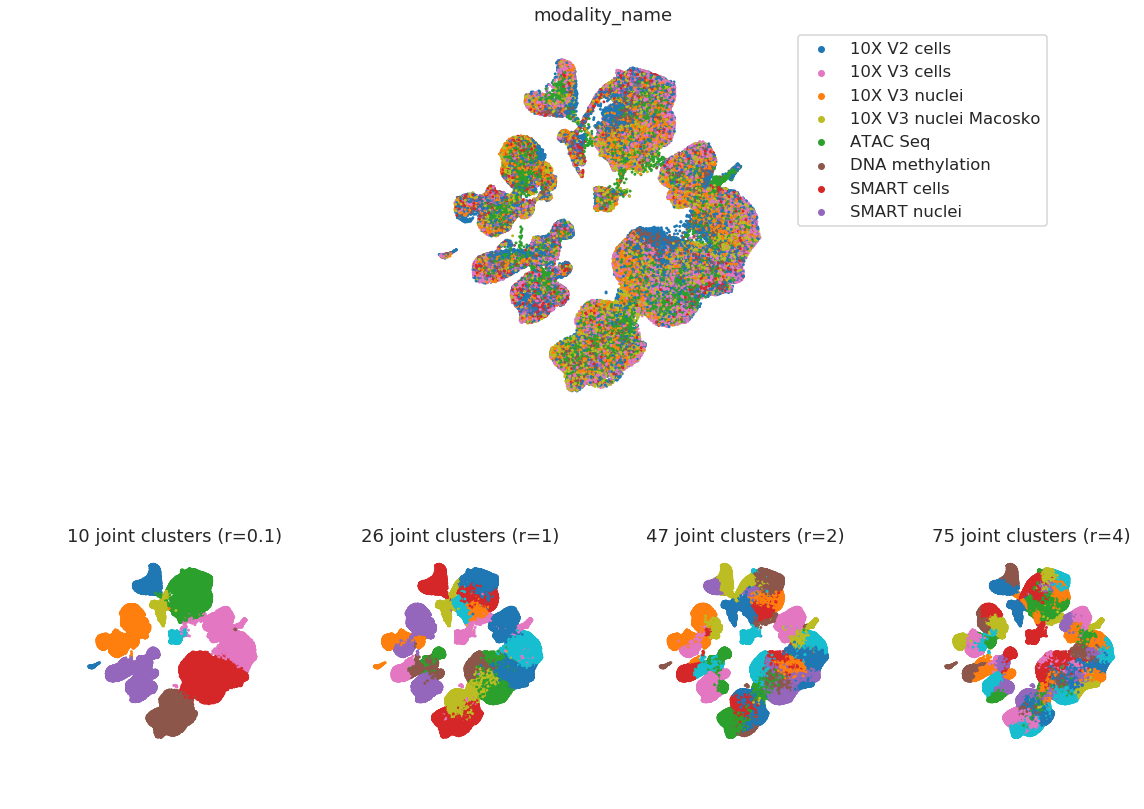

In [10]:
plot_1()

In [11]:
def plot_1_single(kw_colors='', show_labels=False, output=''):
    """plot umap cluster 
    """
    fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', joint_cluster
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                         #  legend_kws=legend_kws,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      kw_colors=kw_colors,
                                      legend_mode=-1,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')
    if show_labels:
        for clst, centroid in centroids['joint'].iterrows():
            facecolor='white'
            ax.text(centroid.values[0], 
                    centroid.values[1], 
                    str(clst)+'_'+joint_annot.loc[clst, 'annot'],
                    color='black', 
                    bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                    fontsize=10,
                   )

    fig.savefig(output, bbox_inches='tight', dpi=300)
    plt.show()
        
def plot_2_single(output=''):
    """Plot umap - modality
    """
    fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
    kw_colors = {settings[mod].name: settings[mod].color for mod in mods_selected}
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                      legend_kws=legend_kws,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      kw_colors=kw_colors,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')

    fig.savefig(output, bbox_inches='tight', dpi=300)
    plt.show()

def plot_3(output='', 
           show_labels=False):
    """Plot umap - cluster - each modality
    """
    n = len(mods_selected)
    nx = 3
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(6*nx,6*ny))
    axs = axs.flatten()
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster'

    for ax, mod in zip(axs, mods_selected):
        snmcseq_utils.plot_tsne_labels_ax(df_info[df_info['modality']==mod], ax, tx, ty, tc, 
                                          sample_n=sample_n,
                                          legend_mode=-1,
                                          rasterized=True,
                                          s=2,
                                         )
        ax.set_title('{} ({} clusters)'.format(settings[mod].name, len(df_info.loc[df_info['modality']==mod, tc].unique())))
    
        if show_labels:
            for clst, centroid in centroids[mod].iterrows():
                facecolor='white'
                ax.text(centroid.values[0], 
                        centroid.values[1], 
                        clst,
                        color='black', 
                        bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                        fontsize=10,
                       )
        ax.set_aspect('equal')
        ax.axis('off')
    for ax in axs[n:]:
        ax.axis('off')


    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    fig.savefig(output, bbox_inches='tight', dpi=300)
    plt.show()


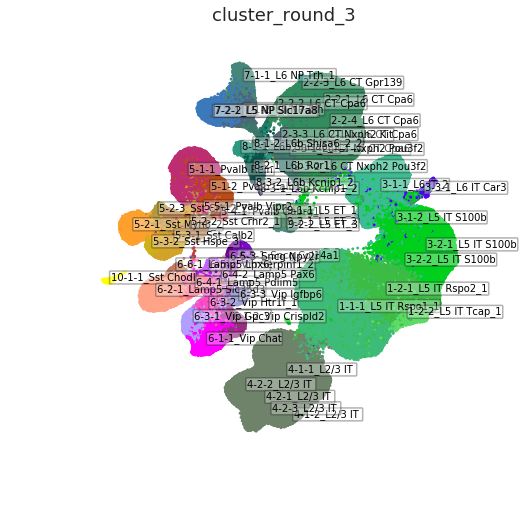

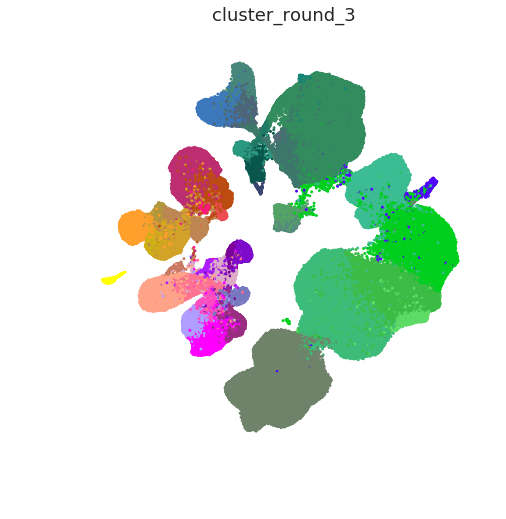

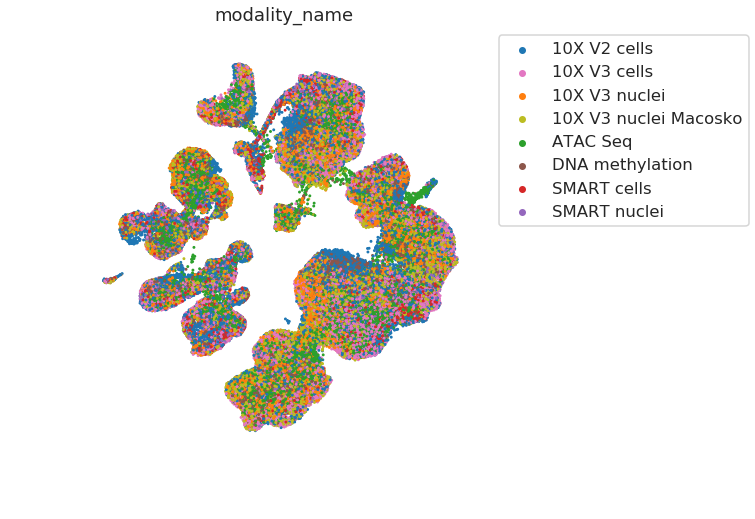

In [12]:
sample_n = 20000
# umap cluster
plot_1_single(joint_clst_colors, show_labels=True, output=output_figures.format('round3_1-label', 'pdf'))
plot_1_single(joint_clst_colors, show_labels=False, output=output_figures.format('round3_1-nolabel', 'pdf'))
plot_2_single(output=output_figures.format('round3_2-nolabel', 'pdf'))

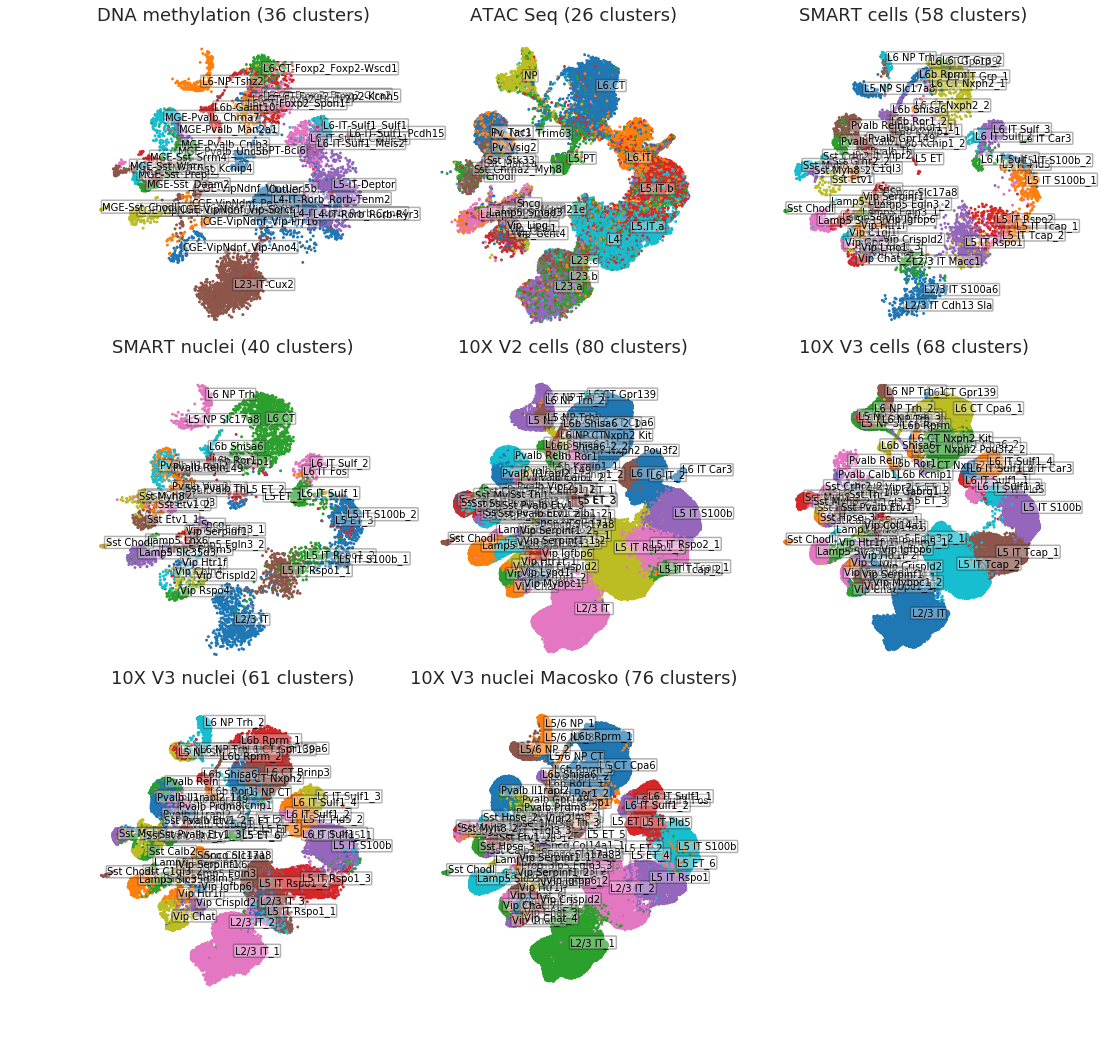

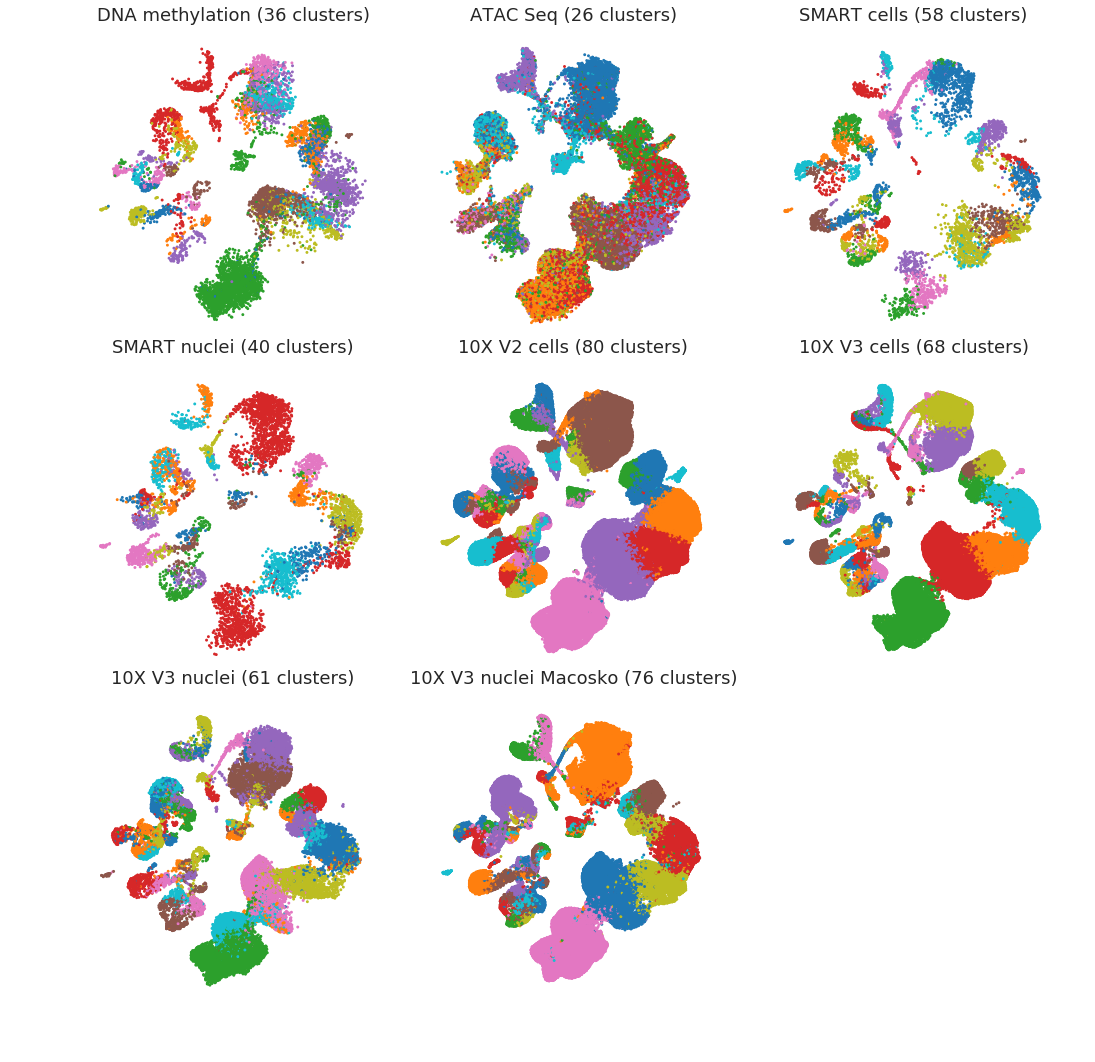

In [13]:
# umap modality
plot_3(show_labels=True, output=output_figures.format('3-label', 'pdf'))
plot_3(show_labels=False, output=output_figures.format('3-nolabel', 'pdf'))

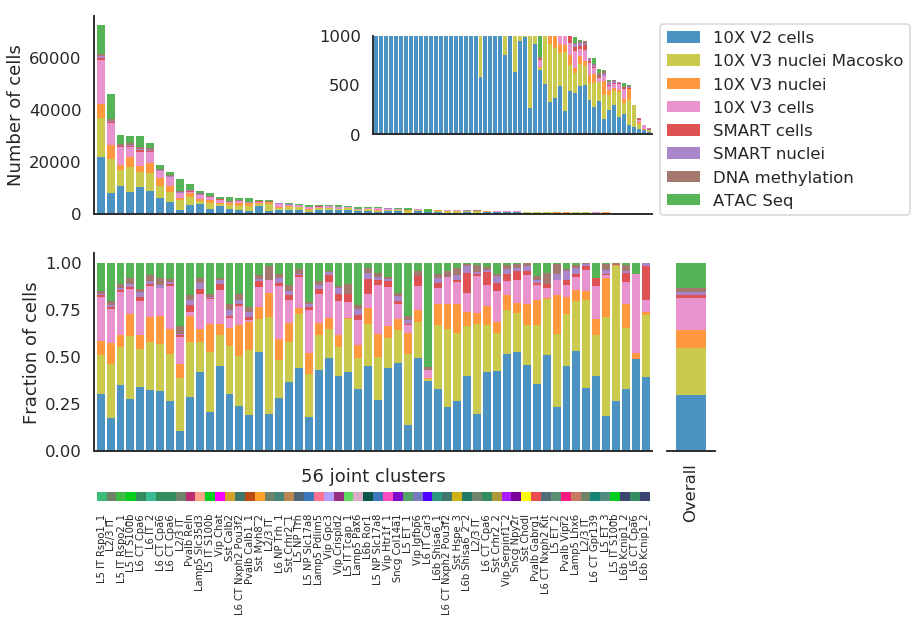

In [14]:

clsts_order = df_info.groupby(joint_cluster).size().sort_values(ascending=False).index.values

# histograms
with sns.axes_style('white', {"patch.edgecolor": "black", 'patch.force_edgecolor': False,}):
    fig, axs = plt.subplots(2, 1, figsize=(10*1,4*2))
    axs = axs.flatten()
    ax = axs[0]
    legend = True
    (hist[mods_ordered[::-1]].rename(index=mod_names, columns=mod_names)
                             .reindex(clsts_order)
                             .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax,
                                       legend=legend,
                                      color=[val for key, val in mod_colors.items()][::-1], # this controls mod_colors
                                     )
    )
    sns.despine(ax=ax)
    ax.set_ylabel('Number of cells')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    axs[0].legend(bbox_to_anchor=(1, 1))
    
    num_th = 1000
    legend = False
    left_x, left_y, width, height = ax.get_position().bounds
    ax = fig.add_axes((left_x+0.5*width, left_y+0.4*height, 0.5*(width), 0.5*height))
    (hist[mods_ordered[::-1]].rename(index=mod_names, columns=mod_names)
#                              [hist.sum(axis=1)<num_th]
                             .reindex(clsts_order)
                             .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax,
                                       legend=legend,
                                      color=[val for key, val in mod_colors.items()][::-1], # this controls mod_colors
                                     )
    )
    sns.despine(ax=ax)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    ax.set_ylim([0, num_th])
    
    ax = axs[1]
    (hist_frac[mods_ordered[::-1]].rename(index=mod_names, columns=mod_names)
                             .reindex(clsts_order)
                             .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                                      color=[val for key, val in mod_colors.items()][::-1], # this controls mod_colors
                                     )
    )
    sns.despine(ax=ax)
    ax.set_ylabel('Fraction of cells')
    ax.set_xlabel('{} joint clusters'.format(len(hist)))
    ax.set_xticklabels([])
    
#     ax = fig.add_axes([.95, .5, .05, .4])
    left_x, left_y, width, height = ax.get_position().bounds
    ax = fig.add_axes((left_x+width+0.2*(1-(left_x+width)), left_y, 0.3*(1-width), height))
    ((hist_mod/hist_mod.sum()).loc[mods_ordered[::-1]].to_frame().T.rename({0: 'Overall'}, axis=0)
                              .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                                      color=[val for key, val in mod_colors.items()][::-1]) # this controls mod_colors
    )
    sns.despine(left=True, ax=ax)
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
    ax = fig.add_axes((left_x, left_y-0.7*left_y, width, 0.05*height))
    to_plot = pd.DataFrame()
    to_plot['color'] = joint_annot.loc[hist.reindex(clsts_order).index, 'cluster_color']
    to_plot['annot'] = joint_annot.loc[hist.reindex(clsts_order).index, 'annot']
    to_plot['bar'] = 1
    (to_plot['bar'].plot.bar(stacked=True, width=1, 
                     alpha=1, 
                      ax=ax, 
                      legend=False, 
                     color=to_plot['color'].values, 
                     )
    )
    sns.despine(left=True, bottom=True, ax=ax)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels(to_plot['annot'].values, fontsize=10)
    ax.set_yticks([])
    
    
#     fig.tight_layout()
    fig.savefig(output_figures.format('round3_4', 'pdf'), bbox_inches='tight')
    plt.show()

In [15]:
to_plot

color               annot  bar
cluster_round_3                                  
1-1-1            #3CBC78       L5 IT Rspo1_1    1
4-1-1            #6F836B            L2/3 IT     1
1-2-1            #3CBC45       L5 IT Rspo2_1    1
3-2-1            #00CF1E         L5 IT S100b    1
2-2-1            #338C5E          L6 CT Cpa6    1
3-1-1            #3CBC92             L6 IT_2    1
2-1-1            #338C5E          L6 CT Cpa6    1
2-1-2            #338C5E          L6 CT Cpa6    1
4-2-1            #6F836B            L2/3 IT     1
5-1-1            #BC2D71          Pvalb Reln    1
6-2-1            #FFA388       Lamp5 Slc35d3    1
3-1-2            #00CF1E         L5 IT S100b    1
6-1-1            #FF00FF            Vip Chat    1
5-3-1            #D2A328           Sst Calb2    1
2-3-1            #3E766C  L6 CT Nxph2 Pou3f2    1
5-1-2            #BC4B11       Pvalb Calb1_1    1
5-2-1            #FF9F2C          Sst Myh8_2    1
4-2-2            #6F836B            L2/3 IT     1
7-1-1            #47867A         L6 NP Trh_1    1
5-2-2            #BE8652         Sst Crhr2_1    1
7-1-2            #4D6577           L5 NP Trh    1
7-2-1            #3C78BC       L5 NP Slc17a8    1
6-4-1            #FF7290        Lamp5 Pdlim5    1
6-3-1            #B09FFF            Vip Gpc3    1
6-1-2            #992E81        Vip Crispld2    1
1-2-2            #5DDB65        L5 IT Tcap_1    1
6-4-2            #DDACC9          Lamp5 Pax6    1
8-2-1            #09564C            L6b Ror1    1
7-2-2            #3C78BC       L5 NP Slc17a8    1
6-3-2            #FF4DC1         Vip Htr1f_1    1
6-5-1            #7E0ACB        Sncg Col14a1    1
9-1-1            #53A367             L5 ET_1    1
6-3-3            #7779BF          Vip Igfbp6    1
3-3-1            #5100FF          L6 IT Car3    1
8-1-1            #2B9880        L6b Shisa6_1    1
2-3-2            #3E766C  L6 CT Nxph2 Pou3f2    1
5-3-2            #CDB115          Sst Hspe_3    1
8-1-2            #207A66      L6b Shisa6_2_2    1
4-2-3            #6F836B            L2/3 IT     1
2-2-2            #338C5E          L6 CT Cpa6    1
5-2-3            #B0993C         Sst Crhr2_2    1
6-5-2            #AB1DFF      Vip Serpinf1_2    1
6-5-3            #7A0099          Sncg Npy2r    1
10-1-1           #FFFF00           Sst Chodl    1
5-4-1            #ED4C50        Pvalb Gabrg1    1
2-3-3            #516B78     L6 CT Nxph2 Kit    1
9-2-1            #5D8E76             L5 ET_2    1
5-5-1            #FF197F         Pvalb Vipr2    1
6-6-1            #C77963          Lamp5 Lhx6    1
4-1-2            #6F836B            L2/3 IT     1
2-2-3            #168577        L6 CT Gpr139    1
9-2-2            #518C7F             L5 ET_3    1
3-2-2            #00CF1E         L5 IT S100b    1
8-3-1            #3B4670        L6b Kcnip1_2    1
2-2-4            #338C5E          L6 CT Cpa6    1
8-3-2            #3B4670        L6b Kcnip1_2    1

#### Heatmap of correlation of cluster centroids 
- imputed data

In [16]:
mods_included = mods_selected
mod_reference = features_selected[0]
cells_all = np.load(output_cells_all, allow_pickle=True)
imputed_data = np.load(output_imputed_data_format.format(mod_reference), allow_pickle=True)

# cluster centroids of imputed data
cluster_centroids = collections.OrderedDict()
for (clst, mod), df_sub in df_info.groupby([joint_cluster, 'modality']):
    if mod in mods_included:
        cells_sub = df_sub.index.values
        cells_sub_idx = snmcseq_utils.get_index_from_array(cells_all, cells_sub)
        if mod not in cluster_centroids.keys():
            cluster_centroids[mod] = {}
        cluster_centroids[mod][clst] = np.ravel(imputed_data[cells_sub_idx,:].mean(axis=0))
# print(cluster_centroids)

# Saving the objects:
with open(output_cluster_centroids, 'wb') as f: 
    pickle.dump((
                cluster_centroids
                ), f)

In [17]:
cluster_centroids_df = collections.OrderedDict()
for mod in mods_selected:
    if mod in mods_included:
        cluster_centroids_df[mod] = pd.DataFrame(cluster_centroids[mod])

# each modality and cluster
uniq_clusters = df_info[joint_cluster].unique()
corr_grand_clusters = np.hstack([[mod+'_'+str(clst)
                                for clst in cluster_centroids_df[mod].columns.values]
                                for mod in mods_included])

# grand correlation matrix
corr_grand = {}
for i, mod_x in enumerate(mods_included):
    for j, mod_y in enumerate(mods_included):
        if j >= i:
            gene_x = cluster_centroids_df[mod_x].index.values
            gene_y = cluster_centroids_df[mod_y].index.values
            gene_common = np.intersect1d(gene_x, gene_y)
            _x = (cluster_centroids_df[mod_x].loc[gene_common]).rank(axis=0).T.values
            _y = (cluster_centroids_df[mod_y].loc[gene_common]).rank(axis=0).T.values
            corr = np.corrcoef(_x, _y)[:len(_x), len(_x):]
            corr_grand[(i, j)] = corr
            if j != i:
                corr_grand[(j, i)] = corr.T
                
corr_grand = np.hstack([np.vstack([
                    corr_grand[(i, j)] for i in range(len(mods_included))
                    ])
                for j in range(len(mods_included))
                ])

# labels
# corr_grand_label = np.hstack([[str(clst) + "_" + str(joint_annot.loc[clst, 'annot'])
#                                for clst in cluster_centroids_df[mod].columns.values] 
#                             for mod in mods_included
#                             ])
corr_grand_label = np.hstack([[str(joint_annot.loc[clst, 'annot'])
                               for clst in cluster_centroids_df[mod].columns.values] 
                            for mod in mods_included
                            ])
corr_grand_clsts = np.hstack([cluster_centroids_df[mod].columns.values
                            for mod in mods_included
                            ])
corr_grand_mods = np.hstack([
                            [mod]*len(cluster_centroids_df[mod].columns.values) for mod in mods_included
                            ])

# colors
corr_grand_mod_colors = np.array([settings[mod].color for mod in corr_grand_mods])
corr_grand_clst_colors = np.array([joint_clst_colors[clst] for clst in corr_grand_clsts])

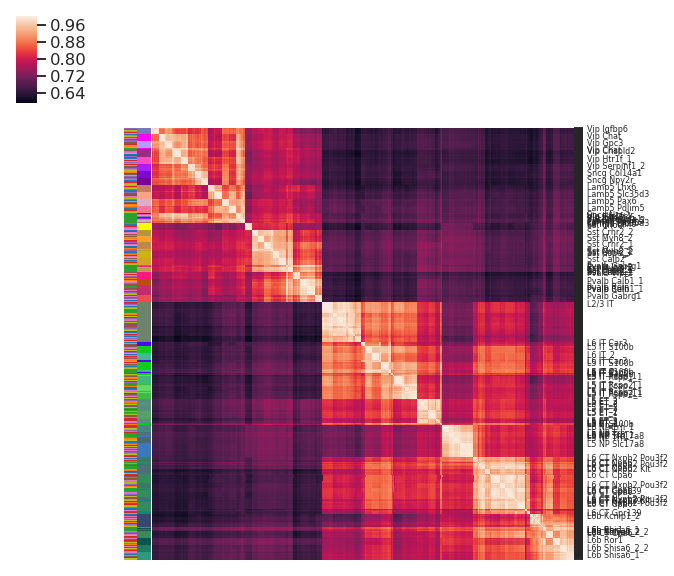

In [18]:
mat = corr_grand
Z = sch.linkage(mat, method='average')
dn = sch.dendrogram(Z, no_plot=True)
yticklabels = snmcseq_utils.dedup_array_elements(corr_grand_label[dn['leaves']])

g = sns.clustermap(mat[dn['leaves'],:][:,dn['leaves']], 
                   row_cluster=False, col_cluster=False,
                   row_colors=[corr_grand_mod_colors[dn['leaves']], 
                               corr_grand_clst_colors[dn['leaves']], 
                              ], 
                   yticklabels=yticklabels,
                   xticklabels=[],
#                    figsize=(8, 12),
                  )
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=8)
g.savefig(output_figures.format('round3_8_cluster_heatmap', 'pdf'), bbox_inches='tight')
plt.show()

### Confusion matrix

In [19]:
def plot_5_version2(base_cluster, joint_cluster, 
                    order_joint,
           output='',
          ):
    nx = len(mods_ordered)
    ny = 2
    heatmap_kws = {
        'xticklabels': False, 
        'yticklabels': False,
        'vmin': 0, 
        'vmax': 1,
        'cmap': 'Reds',
    }

    cbar_kws = {
        'orientation': 'vertical', 
        'label': 'Fraction of cells',
    }

    with sns.plotting_context('talk'):
        fig, axs = plt.subplots(ny, nx, figsize=(3*nx, 3*ny))
        axs = axs.T
        cbar_ax = fig.add_axes([0.95, 0.4, 0.03, 0.3])
        njoint_clusters = len(df_info[joint_cluster].unique())
        for i, (mod, ax) in enumerate(zip(mods_ordered[::-1], axs)):
            conf_mat = pd.crosstab(df_info.loc[df_info['modality']==mod, base_cluster], 
                                   df_info.loc[df_info['modality']==mod, joint_cluster],
                                  ) #.fillna(0)
            # normalize each joint cluster
            conf_mat_njoint = conf_mat.divide(conf_mat.sum(axis=0), axis=1)
            # normalize each orig cluster
            conf_mat_norig = conf_mat.divide(conf_mat.sum(axis=1), axis=0)

            # plot normalized by joint 
            if i == 0:
                ylabel = 'Row normalized\n{} joint clusters'.format(njoint_clusters)
                cbar = True
            else:
                ylabel = ''
                cbar = False
                
            order_joint = order_joint_sch
            _X = conf_mat_njoint.reindex(order_joint, axis=1, fill_value=0) 
            _rX, ri, rc = snmcseq_utils.diag_matrix_rows(_X.values, _X.index.values, _X.columns.values)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=cbar,
                        cbar_kws=cbar_kws,
                        cbar_ax=cbar_ax,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            g.axes.set_title('{}\n{} clusters'.format(settings[mod].name, _rX.shape[0]))
            g.axes.set_ylabel(ylabel)
            order_orig = _rX.index.values # Will be fixed for the mod clusters  
            # bounding box
            for _, spine in g.axes.spines.items():
                spine.set_visible(True)
                spine.set_color(settings[mod].color)

            # plot normalized by orig (according to the axis of normalized by joint) 
            _X = conf_mat_norig.reindex(order_orig, axis=0).reindex(order_joint, axis=1).fillna(0)
            g = sns.heatmap(_X.T, 
                        cbar=False,
                        ax=ax[1],
                        **heatmap_kws,
                       )
            if i == 0:
                g.axes.set_xlabel('')
                g.axes.set_ylabel('Col normalized\n{} joint clusters'.format(njoint_clusters))
            else:
                g.axes.set_xlabel('')
                g.axes.set_ylabel('')
            # bounding box
            for _, spine in g.axes.spines.items():
                spine.set_visible(True)
                spine.set_color(settings[mod].color)

        plt.subplots_adjust(hspace=0.05, wspace=0.05)
        fig.savefig(output, bbox_inches='tight')
        plt.show()

In [20]:
# get cluster order
_mat = pd.DataFrame(cluster_centroids['10x_cells_v2']).T
Z = sch.linkage(_mat.values, method='average')
order_joint_sch = _mat.index.values[sch.dendrogram(Z, no_plot=True)['leaves']]

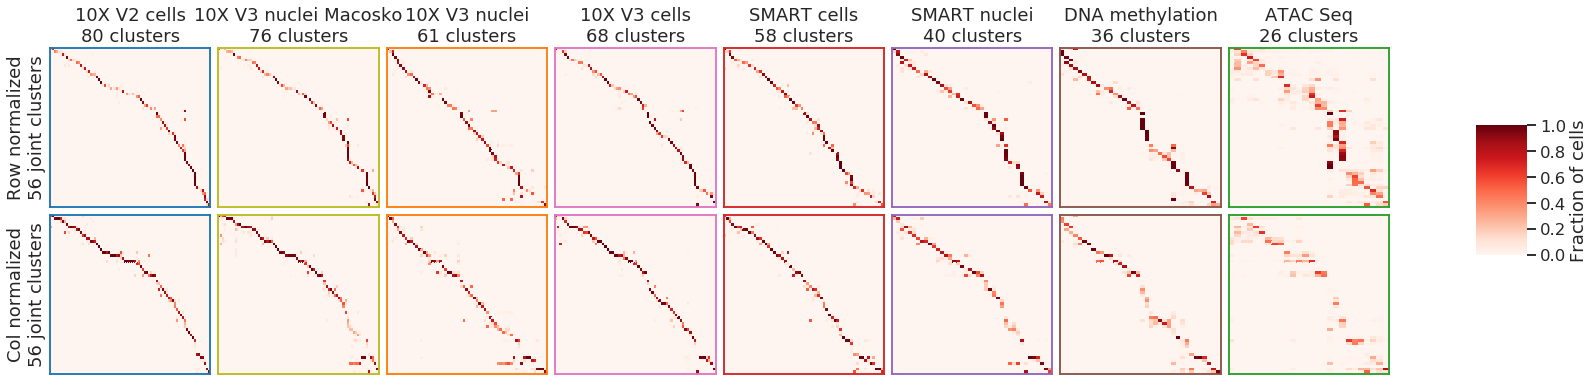

In [21]:
base_cluster = 'cluster'
plot_5_version2(base_cluster, joint_cluster, order_joint_sch, 
       output=output_figures.format('round3_5', 'pdf'),
       )

### tSNE plot

In [22]:
# cluster centroids of imputed data
base_cluster = 'cluster'
cluster_centroids_single = collections.OrderedDict()
for (clst, mod), df_sub in df_info.groupby([base_cluster, 'modality']):
    if mod in mods_included:
        cells_sub = df_sub.index.values
        cells_sub_idx = snmcseq_utils.get_index_from_array(cells_all, cells_sub)
        if mod not in cluster_centroids_single.keys():
            cluster_centroids_single[mod] = {}
        cluster_centroids_single[mod][clst] = np.ravel(imputed_data[cells_sub_idx,:].mean(axis=0))
        
cluster_centroids_single['intg'] = {}
for clst, df_sub in df_info.groupby([joint_cluster]):
    cells_sub = df_sub.index.values
    cells_sub_idx = snmcseq_utils.get_index_from_array(cells_all, cells_sub)
    cluster_centroids_single['intg'][clst] = np.ravel(imputed_data[cells_sub_idx,:].mean(axis=0))

In [23]:
base_annot = df_info.groupby(['modality', 'cluster']).first()[['annot']].reset_index()
intg_annot = joint_annot.reset_index().rename(columns={joint_cluster: 'cluster'})
intg_annot['modality'] = 'intg'
annots = pd.concat([base_annot, intg_annot], sort=False)

In [24]:
# cluster_centroids
# cluster_meta
dfs = []
centroids_meta = []
        
for mod, mod_centroids in cluster_centroids_single.items():
    df = pd.DataFrame(mod_centroids)
    for col in df.columns.values:
        centroids_meta.append({
            'modality': mod,
            'cluster': col,
            })
    df.columns = [mod + '_' + str(col) for col in df.columns.values]
    dfs.append(df)
dfs = pd.concat(dfs, axis=1)

centroids_meta = pd.DataFrame(centroids_meta)
centroids_meta['sample'] = (centroids_meta['modality'] + '_' + centroids_meta['cluster'].astype(str)).values

print(centroids_meta.shape)
centroids_meta.head()

df_umap = CEMBA_run_tsne.run_umap(dfs, n_neighbors=10, n_pc=50, min_dist=0.7)
df_umap = df_umap.join(centroids_meta.set_index('sample'))
df_umap = pd.merge(df_umap.reset_index(), annots, on=['cluster', 'modality']).set_index('sample')

print(df_umap.shape)
df_umap.head()

(501, 3)


09/30/2019 10:54:30 PM Running tsne: 50 PC, 10 n_neighbors, 0.7 min_dist , 2 dim.
Input shape: (4067, 501)
09/30/2019 10:54:35 PM Done with tSNE. running time: 5.233555555343628 seconds.


(503, 6)


tsne_x    tsne_y cluster      modality         annot  \
sample                                                                     
10x_cells_v2_1    2.149916  2.052985       1  10x_cells_v2    Lamp5 Pax6   
10x_cells_v2_10 -13.766674 -4.824399      10  10x_cells_v2    Sncg Npy2r   
10x_cells_v2_11 -15.263106 -4.086260      11  10x_cells_v2  Sncg Calb1_1   
10x_cells_v2_12 -14.583641 -4.820374      12  10x_cells_v2  Sncg Calb1_2   
10x_cells_v2_13 -11.996245 -3.456012      13  10x_cells_v2  Vip Crispld2   

                cluster_color  
sample                         
10x_cells_v2_1            NaN  
10x_cells_v2_10           NaN  
10x_cells_v2_11           NaN  
10x_cells_v2_12           NaN  
10x_cells_v2_13           NaN

09/30/2019 10:54:35 PM No handles with labels found to put in legend.


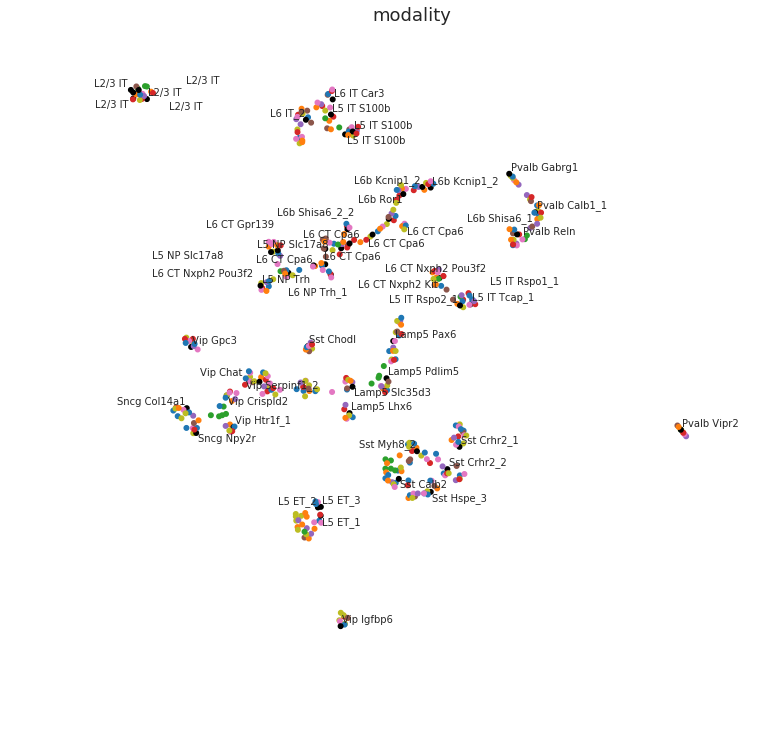

In [25]:
from adjustText import adjust_text
np.random.seed(0)

kw_colors = mod_colors.copy()
kw_colors['intg'] = 'black'

fig, ax = plt.subplots(figsize=(12,12))
tx, ty, tc = 'tsne_x', 'tsne_y', 'modality'
legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
# cond = df_umap['annot'].str.contains(r'^Pv')
cond = ~df_umap['modality'].isnull()
snmcseq_utils.plot_tsne_labels_ax(df_umap[cond], ax, tx, ty, tc, 
                                  legend_kws=legend_kws,
                                  kw_colors=kw_colors,
                                  sample_n=sample_n,
#                                   legend_size=30,
                                  legend_mode=-1,
                                  rasterized=True,
                                  s=20,
                                 )
texts = []
for idx, row in df_umap[df_umap['modality']=='intg'].iterrows():
    _x, _y, _label = row[tx], row[ty], row['annot']
    texts.append(ax.text(_x, _y, _label))
adjust_text(texts)
# ax.set_aspect('equal')
ax.get_legend().remove()
ax.axis('off')
output = output_figures.format('round3_10', 'pdf')
fig.savefig(output, dpi=300, bbox_inches='tight')
plt.show()

# Gene level features:

In [26]:
df_genes = pd.read_csv(PATH_GENEBODY_ANNOTATION, sep='\t')
df_genes['gene_id_abbr'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
df_genes = df_genes.set_index('gene_id_abbr')
print(df_genes.shape)
df_genes.head()

(53379, 7)


gene_id      gene_name   chr    start  \
gene_id_abbr                                                             
ENSMUSG00000102693  ENSMUSG00000102693.1  4933401J01Rik  chr1  3073253   
ENSMUSG00000064842  ENSMUSG00000064842.1        Gm26206  chr1  3102016   
ENSMUSG00000051951  ENSMUSG00000051951.5           Xkr4  chr1  3205901   
ENSMUSG00000102851  ENSMUSG00000102851.1        Gm18956  chr1  3252757   
ENSMUSG00000103377  ENSMUSG00000103377.1        Gm37180  chr1  3365731   

                        end strand             gene_type  
gene_id_abbr                                              
ENSMUSG00000102693  3074322      +                   TEC  
ENSMUSG00000064842  3102125      +                 snRNA  
ENSMUSG00000051951  3671498      -        protein_coding  
ENSMUSG00000102851  3253236      +  processed_pseudogene  
ENSMUSG00000103377  3368549      -                   TEC

In [27]:
df_genes_v2 = df_genes.reset_index().groupby('gene_name').first()
df_genes_v2.head()

gene_id_abbr               gene_id    chr      start  \
gene_name                                                                   
0610005C13Rik  ENSMUSG00000109644  ENSMUSG00000109644.1   chr7   45567794   
0610006L08Rik  ENSMUSG00000108652  ENSMUSG00000108652.1   chr7   74818818   
0610009B22Rik  ENSMUSG00000007777  ENSMUSG00000007777.9  chr11   51685386   
0610009E02Rik  ENSMUSG00000086714  ENSMUSG00000086714.1   chr2   26445696   
0610009L18Rik  ENSMUSG00000043644  ENSMUSG00000043644.4  chr11  120348678   

                     end strand                      gene_type  
gene_name                                                       
0610005C13Rik   45575327      -                  antisense_RNA  
0610006L08Rik   74853813      -                        lincRNA  
0610009B22Rik   51688874      -                 protein_coding  
0610009E02Rik   26459390      +           processed_transcript  
0610009L18Rik  120351190      +  bidirectional_promoter_lncRNA

In [28]:
f_meta_format = '{0}/{1}_metadata.tsv'
f_data_format = '{0}/{1}_{2}raw.{3}'
f_hvftr_format = '{0}/{1}_hvfeatures.{2}'
f_ftr_format = '{0}/{1}_features.{2}'

In [29]:
gxc_ftrs = {}
for mod in mods_selected:
    ti = time.time()
    print(mod)
    
    # read data matrix
    if settings[mod].mod_category == 'mc':
        f_data = f_ftr_format.format(DATA_DIR, mod, 'tsv')
        # read in files
        print(mod, "Reading in files {}".format(time.time()-ti))
        gxc_ftrs[mod] = pd.read_csv(f_data, sep='\t', index_col=0)
        print(time.time()-ti)
        
    else:
        f_data = f_ftr_format.format(DATA_DIR, mod, 'npz') 
        f_data_gene = f_ftr_format.format(DATA_DIR, mod, 'gene') 
        f_data_cell = f_ftr_format.format(DATA_DIR, mod, 'cell') 
        
        # read in files
        print(mod, "Reading in files {}".format(time.time()-ti))
        gxc_ftrs[mod] = snmcseq_utils.load_gc_matrix(f_data_gene, f_data_cell, f_data) # checked dimensions in agreement internally
        print(gxc_ftrs[mod].data.shape)
        print(time.time()-ti)
    
    print(mod, "Total time used: {}".format(time.time()-ti))
    

snmcseq_gene
snmcseq_gene Reading in files 5.841255187988281e-05
98.02281212806702
snmcseq_gene Total time used: 98.02297377586365
snatac_gene
snatac_gene Reading in files 3.933906555175781e-05
(53278, 54844)
27.733232736587524
snatac_gene Total time used: 27.733261823654175
smarter_cells
smarter_cells Reading in files 4.363059997558594e-05
(32324, 6244)
9.11808180809021
smarter_cells Total time used: 9.11810564994812
smarter_nuclei
smarter_nuclei Reading in files 4.0531158447265625e-05
(32324, 5911)
5.309687852859497
smarter_nuclei Total time used: 5.309706687927246
10x_cells_v2
10x_cells_v2 Reading in files 2.288818359375e-05
(31053, 121440)
53.557762145996094
10x_cells_v2 Total time used: 53.557788133621216
10x_cells_v3
10x_cells_v3 Reading in files 3.7670135498046875e-05
(31053, 69727)
50.371485471725464
10x_cells_v3 Total time used: 50.37151122093201
10x_nuclei_v3
10x_nuclei_v3 Reading in files 0.0005037784576416016
(31053, 39706)
13.848825216293335
10x_nuclei_v3 Total time used: 

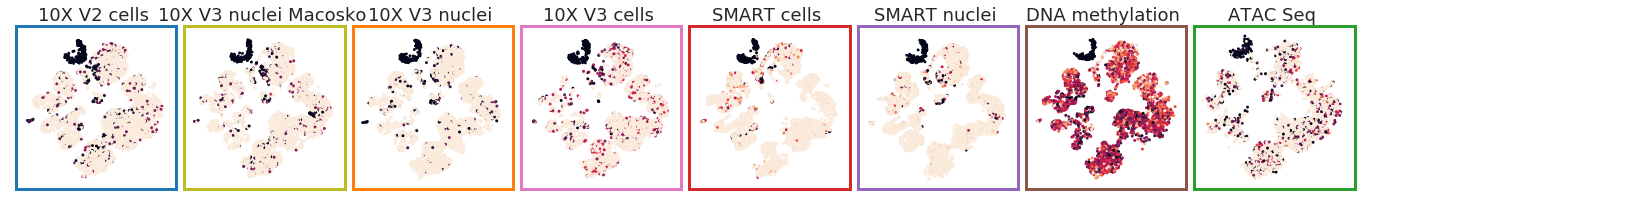

In [30]:
genes_inq = [
    'Tshz2',
#     'Bcl6', 
#     'Slco2a1', 
#     'Hpgd', 
#     'Npsr1', 
#     'Tshz2',
]
    
sample_n = 5000

with sns.axes_style('white'):
    n = len(mods_ordered)
    nx = 9
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(3*nx,3*ny))
    axs = axs.flatten()
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', genes_inq[0]
    
    cbar_ax = fig.add_axes([0.9, 0.2, 0.05, 0.6])
    
    for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
        if settings[mod].mod_category == 'mc':
            genes = gxc_ftrs[mod].index.values
            gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 
            gene_idx = snmcseq_utils.get_index_from_array(genes, gene_ids_inq)
            gene_data = gxc_ftrs[mod].iloc[gene_idx].T.rename(columns={gene_ids_inq[0]: genes_inq[0]})
            # normalize gene_data
        else:
            genes = gxc_ftrs[mod].gene
            cells = gxc_ftrs[mod].cell
            gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 
            gene_idx = snmcseq_utils.get_index_from_array(genes, gene_ids_inq)
            gene_data = np.ravel(gxc_ftrs[mod].data.tocsr()[gene_idx, :].todense())
            gene_data = pd.Series(gene_data, index=cells).to_frame(genes_inq[0])
            
#             # normalize gene_data
#             gene_data = gene_data.applymap(lambda x: np.log10(x+1))
        
        # normalize gene_data
        gene_data = settings[mod].mod_direction*(gene_data - gene_data.mean())/gene_data.std()

        df_mod = df_info[df_info['modality']==mod]
        if sample_n > len(df_mod):
            df_plot = pd.merge(gene_data, df_mod, left_index=True, right_index=True)
        else:
            df_plot = (pd.merge(gene_data, df_mod, left_index=True, right_index=True)
                         .sample(sample_n, replace=False)
                      )
    
        if i == 0: 
            cbar = False
        else:
            cbar = False
        snmcseq_utils.plot_tsne_values_ax(df_plot, ax, tx, ty, tc, 
                                          s=2,
                                          cbar=cbar,
                                          cbar_ax=cbar_ax,
                                          cmap='rocket_r',
                                          rasterized=True,
                                         )
        ax.set_title('{} '.format(settings[mod].name, ))
#         ax.set_title('')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('auto')
        
        for _, spine in ax.spines.items():
            spine.set_color(settings[mod].color)
            spine.set_linewidth(3)
        
    for ax in axs[n:]:
        ax.axis('off')
    cbar_ax.axis('off')
        
    
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.savefig(output_figures.format('6_{}'.format(genes_inq[0]), 'pdf'), bbox_inches='tight', dpi=300)
    plt.show()
    

In [31]:
#     'Camk2a',
#     'Gria1',
#     'Tbr1',
    #'Gad1',
    #'Cux1',
#     'Batf3',
#     'Gpr139',
# 'Slc17a7'
#     'Tacr3',
#     'Myh8',
#     'Crhr2',
#     'Esm1',
#     'Akr1c18',
#     'Sema3e',
#     'Krt73',
#     'Pax6',
#     'Ntn1',
#     'Plch2',
#     'Lsp1',
#     'Nptx2',
#     'Itih5',
#     'Serpinf1',
#     'Lmo1',
#     'Ptprt',
#     'Rspo4',
#     'Col15a1',
#     'Slc6a1',
#     'Prox1',
#     'Fam84b',
#     'Vat1l',
#     'Sulf1',
#     # L6 all 
#     'Tle4',
# L5 ET
#     'Hsd11b1',
#     'Chrna6',
#     'Nts',
# Chodl
#     'Nos1',
#     'Gabrg1',
#     'Chodl',

# 'Grik3'
genes_inq = [
    # neuron
    'Snap25',
    # Exc
    'Satb2',
    # Inh 
    'Gad2',
    
    # Projecting (IT ET CT L6b)
    'Pde1a', # Pan-projection 
    # NP
    'Tshz2', 
    # MGE
    'Sox6',
    'Lhx6',
    # CGE
    'Adarb2',
    
    # IT
    'Slc30a3',
    # IT sub
    # L2-4 
    'Cux2',
    # L4-5
    'Rorb',
    # L5 
    'Deptor',
    # L6
    'Oprk1',
    
    # L5 ET
    'Bcl6',
    
    # L6 CT
    'Foxp2',
    # L6b
    'Nxph4',
    
    # NP again
    'Trhr',
    'Rapgef3',
    'Slc17a8',
    
    # Pv
    'Pvalb',
    'Th',
    'Tac1',
    'Mme',
    'Unc5b',
    # Sst
    'Calb1',
    'Crhr2',
    'Hpse',
    'Chodl',
    
    # Vip Serpinf1
    'Calb2',
    'Vip',
    'Chat',
    'Col15a1',
    'Serpinf1',
    
    # Lamp5 Sncg
    'Lamp5',
    'Sv2c',
    'Plch2',
    'Ntn1',
    
    'Ndnf',
#     'Pax6',
#     'Nr2f2',
    'Reln',
    ]

# assert len(set(genes_inq)) == len(genes_inq)
print([item for item, count in collections.Counter(genes_inq).items() if count > 1])

genes_intersection = set()
for mod in mods_selected:
    if settings[mod].mod_category == 'mc':
        genes = gxc_ftrs[mod].index.values
    else:
        genes = gxc_ftrs[mod].gene
        
    if len(genes_intersection) > 0:
        genes_intersection = set(genes) & set(genes_intersection)
    else:
        genes_intersection = genes 
print(len(genes_intersection))
genes_intersection = df_genes.loc[genes_intersection, 'gene_name'].values
for gene in genes_inq:
    if gene not in genes_intersection:
        print(gene)

[]
15543


In [32]:
joint_annot.sort_values('annot').to_dict()

{'annot': {'1-1-1': 'L5 IT Rspo1_1',
  '1-2-1': 'L5 IT Rspo2_1',
  '1-2-2': 'L5 IT Tcap_1',
  '10-1-1': 'Sst Chodl',
  '2-1-1': 'L6 CT Cpa6',
  '2-1-2': 'L6 CT Cpa6',
  '2-2-1': 'L6 CT Cpa6',
  '2-2-2': 'L6 CT Cpa6',
  '2-2-3': 'L6 CT Gpr139',
  '2-2-4': 'L6 CT Cpa6',
  '2-3-1': 'L6 CT Nxph2 Pou3f2',
  '2-3-2': 'L6 CT Nxph2 Pou3f2',
  '2-3-3': 'L6 CT Nxph2 Kit',
  '3-1-1': 'L6 IT_2',
  '3-1-2': 'L5 IT S100b',
  '3-2-1': 'L5 IT S100b',
  '3-2-2': 'L5 IT S100b',
  '3-3-1': 'L6 IT Car3',
  '4-1-1': 'L2/3 IT ',
  '4-1-2': 'L2/3 IT ',
  '4-2-1': 'L2/3 IT ',
  '4-2-2': 'L2/3 IT ',
  '4-2-3': 'L2/3 IT ',
  '5-1-1': 'Pvalb Reln',
  '5-1-2': 'Pvalb Calb1_1',
  '5-2-1': 'Sst Myh8_2',
  '5-2-2': 'Sst Crhr2_1',
  '5-2-3': 'Sst Crhr2_2',
  '5-3-1': 'Sst Calb2',
  '5-3-2': 'Sst Hspe_3',
  '5-4-1': 'Pvalb Gabrg1',
  '5-5-1': 'Pvalb Vipr2',
  '6-1-1': 'Vip Chat',
  '6-1-2': 'Vip Crispld2',
  '6-2-1': 'Lamp5 Slc35d3',
  '6-3-1': 'Vip Gpc3',
  '6-3-2': 'Vip Htr1f_1',
  '6-3-3': 'Vip Igfbp6',
  '6-4-1': 

In [33]:
clsts_manual_order = collections.OrderedDict({
      '4-1-1': 'L2/3 IT ',
      '4-1-2': 'L2/3 IT ',
      '4-2-1': 'L2/3 IT ',
      '4-2-2': 'L2/3 IT ',
      '4-2-3': 'L2/3 IT ',
      '1-1-1': 'L5 IT Rspo1_1',
      '1-2-1': 'L5 IT Rspo2_1',
      '1-2-2': 'L5 IT Tcap_1',
      '3-1-2': 'L5 IT S100b',
      '3-2-1': 'L5 IT S100b',
      '3-2-2': 'L5 IT S100b',
      '3-1-1': 'L6 IT_2',
      '3-3-1': 'L6 IT Car3',
    
      '9-1-1': 'L5 ET_1',
      '9-2-1': 'L5 ET_2',
      '9-2-2': 'L5 ET_3',
    
      '2-1-1': 'L6 CT Cpa6',
      '2-1-2': 'L6 CT Cpa6',
      '2-2-1': 'L6 CT Cpa6',
      '2-2-2': 'L6 CT Cpa6',
      '2-2-3': 'L6 CT Gpr139',
      '2-2-4': 'L6 CT Cpa6',
      '2-3-1': 'L6 CT Nxph2 Pou3f2',
      '2-3-2': 'L6 CT Nxph2 Pou3f2',
      '2-3-3': 'L6 CT Nxph2 Kit',
    
      '8-1-1': 'L6b Shisa6_1',
      '8-1-2': 'L6b Shisa6_2_2',
      '8-2-1': 'L6b Ror1',
      '8-3-1': 'L6b Kcnip1_2',
      '8-3-2': 'L6b Kcnip1_2',
    
      '7-1-1': 'L6 NP Trh_1',
      '7-1-2': 'L5 NP Trh',
      '7-2-1': 'L5 NP Slc17a8',
      '7-2-2': 'L5 NP Slc17a8',
    
      '5-4-1': 'Pvalb Gabrg1',
      '5-1-1': 'Pvalb Reln',
      '5-1-2': 'Pvalb Calb1_1',
      '5-5-1': 'Pvalb Vipr2',
    
      '5-2-1': 'Sst Myh8_2',
      '5-2-2': 'Sst Crhr2_1',
      '5-2-3': 'Sst Crhr2_2',
      '5-3-1': 'Sst Calb2',
      '5-3-2': 'Sst Hspe_3',
      '10-1-1': 'Sst Chodl',
    
      '6-1-1': 'Vip Chat',
      '6-1-2': 'Vip Crispld2',
      '6-3-1': 'Vip Gpc3',
      '6-3-2': 'Vip Htr1f_1',
      '6-5-3': 'Sncg Npy2r',
      '6-3-3': 'Vip Igfbp6',
      '6-5-2': 'Vip Serpinf1_2',
      '6-5-1': 'Sncg Col14a1',
    
      '6-6-1': 'Lamp5 Lhx6',
      '6-2-1': 'Lamp5 Slc35d3',
      '6-4-1': 'Lamp5 Pdlim5',
      '6-4-2': 'Lamp5 Pax6',
    
})

clsts_uniq = np.array(list(clsts_manual_order.keys()))

In [34]:
sample_n = 1e7

In [35]:
# clsts_uniq = np.sort(np.unique(df_info[joint_cluster]))

df_plots = {} 
for i, mod in enumerate(mods_ordered[::-1]):
    if settings[mod].mod_category == 'mc':
        genes = gxc_ftrs[mod].index.values
        gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 
        gene_idx = snmcseq_utils.get_index_from_array(genes, gene_ids_inq)
        gene_idx = gene_idx[gene_idx!=-1] # remove -1
        gene_data = (gxc_ftrs[mod].iloc[gene_idx].T
                                  .rename(columns={a: b for a, b in zip(gene_ids_inq, genes_inq)})
                    )
        # normalize gene_data
    else:
        genes = gxc_ftrs[mod].gene
        cells = gxc_ftrs[mod].cell
        gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 
        gene_idx = snmcseq_utils.get_index_from_array(genes, gene_ids_inq)
        gene_idx = gene_idx[gene_idx!=-1] # remove -1
        
        gene_data = gxc_ftrs[mod].data.tocsr()[gene_idx, :].todense().T
        gene_data = (pd.DataFrame(gene_data, index=cells, columns=gene_ids_inq)
                       .rename(columns={a: b for a, b in zip(gene_ids_inq, genes_inq)})
                    )
#         # normalize gene_data
    
    
    df_mod = df_info.loc[df_info['modality']==mod, [joint_cluster]]
    if sample_n > len(df_mod):
        df_plot = pd.merge(gene_data, df_mod, left_index=True, right_index=True)
    else:
        df_plot = (pd.merge(gene_data, df_mod, left_index=True, right_index=True)
                     .sample(sample_n, replace=False)
                  )
    df_plot = df_plot.groupby(joint_cluster).mean()
    
    # normalize gene_data for each row except for mC (already normalized)
    df_plot = settings[mod].mod_direction*df_plot
    if settings[mod].mod_category != 'mc':
        df_plot = df_plot.divide(df_plot.max(axis=1), axis=0)
        
    df_plots[mod] = df_plot.T.reindex(
                                    index=genes_inq, 
                                    columns=clsts_uniq,
                                    )

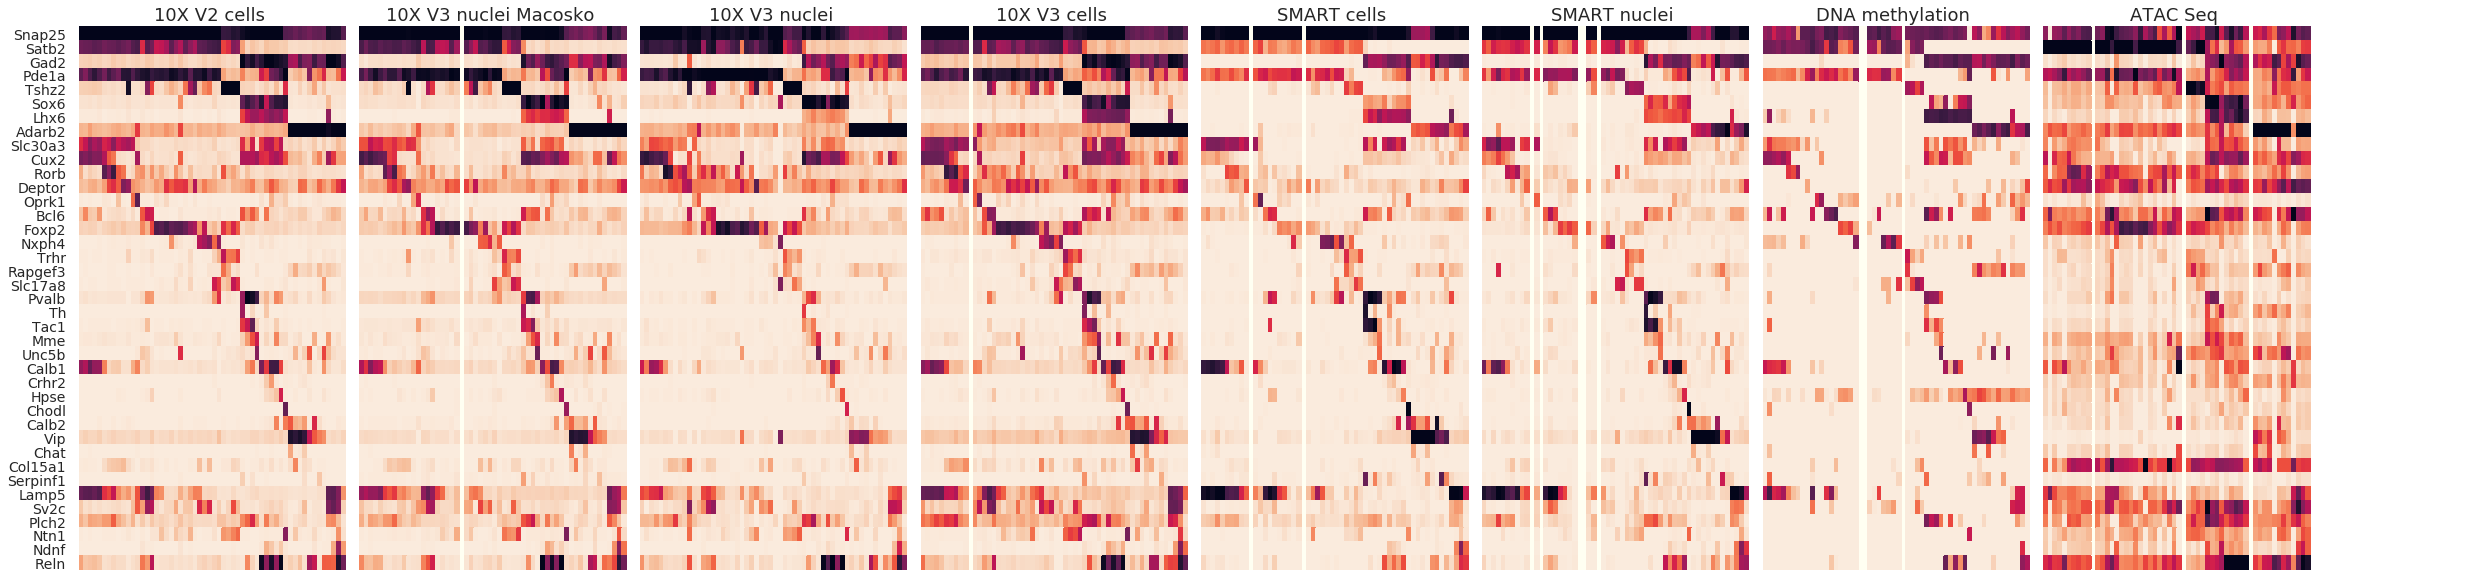

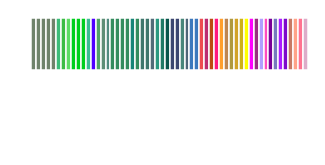

In [36]:
import scipy.cluster.hierarchy as sch
with sns.axes_style('white'):
    n = len(mods_ordered)
    nx = 8
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(5*nx,10*ny))
    axs = axs.flatten()
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', genes_inq[0]
    cbar_ax = fig.add_axes([0.9, 0.2, 0.05, 0.6])
    
    for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
        if i == 0: 
            cbar = False
            
#             # row gene
#             Z = sch.linkage(df_plots[mod].fillna(0), method='average', metric='euclidean', optimal_ordering=True)
#             dn = sch.dendrogram(Z, no_plot=True)['leaves']
            # col clst
#             Z = sch.linkage(df_plots[mod].fillna(0).T, method='average', metric='euclidean', optimal_ordering=True)
#             dn_clst = sch.dendrogram(Z, no_plot=True)['leaves']
        else:
            cbar = False
            
        if settings[mod].mod_category == 'mc':
            vmin, vmax = -1, 0
        else:
            vmin, vmax = 0, 1
            
        g = sns.heatmap(df_plots[mod]
#                             .iloc[dn, dn_clst],
                            .loc[genes_inq, :]
#                             [order_joint_sch], 
                            [clsts_uniq], 
#                             .iloc[:, dn_clst],
                                    ax=ax, 
                                     cbar=cbar,
                                     yticklabels=True,
                                     cbar_ax=cbar_ax,
                                     cmap='rocket_r',
#                                      robust=True,
                                    vmin=vmin,
                                    vmax=vmax,
                                     )
        g.set_facecolor('#fffff2')
        ax.set_title('{} '.format(settings[mod].name, ))
        ax.set_xticks([])
        
        if i == 0:
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
        else:
            ax.set_yticks([])
        ax.set_xlabel('')
            
        ax.set_aspect('auto')
        
        for _, spine in ax.spines.items():
            spine.set_color(settings[mod].color)
            spine.set_linewidth(3)
        
    for ax in axs[n:]:
        ax.axis('off')
    cbar_ax.axis('off')
        
    
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.savefig(output_figures.format('round3_7_gene_heatmap', 'pdf'), bbox_inches='tight')
    plt.show()
    
fig, ax_clst = plt.subplots(figsize=(5, 1))
# left_x, left_y, width, height = ax.get_position().bounds
# ax_clst = fig.add_axes((left_x, left_y-0.5*left_y, width, 0.05*height))
to_plot = pd.DataFrame()
to_plot['color'] = joint_annot.loc[clsts_uniq, 'cluster_color']
to_plot['bar'] = 1
(to_plot['bar'].plot.bar(stacked=True, width=1, 
                 alpha=1, 
                  ax=ax_clst, 
                  legend=False, 
                 color=to_plot['color'].values, 
                 )
)
ax_clst.axis('off')
fig.savefig(output_figures.format('round3_7_gene_heatmap_cluster_color_bars', 'pdf'), bbox_inches='tight')
plt.show()

### Test new 

In [49]:
genes_inq = [
    'Arc',
    'Bdnf', 
    'Cbln2', 
    'Crhbp', 
#     'Dnalb5', 
    'Eef1e1', 
    'Egr1', 
    'Egr2',
    'Egr4', 
    'Fam19a1', 
    'Fam46a', 
    'Fbxo33', 
    'Fmnl1', 
    'Fos', 
    'Fosb', 
    'Fosl2', 
    'Frmd6',
    'Gars', 
    'Gfod1', 
    'Homer1', 
    'Hspa5', 
    'Hspa8', 
    'Ifrd1', 
    'Irs2', 
    'Junb', 
    'Midn', 
    'Nefm', 
#     'Nhp2l1', 
#     'Nm1', 
    'Nptx2', 
    'Npy', 
    'Nr4a1', 
    'Nr4a2', 
    'Nr4a3',
    'Ntrk2', 
    'Ppme1', 
    'Rheb', 
    'Scg2', 
    'Spry2', 
    'Tpt1', 
    'Tsnax', 
    'Vgf',
]

# assert len(set(genes_inq)) == len(genes_inq)
print([item for item, count in collections.Counter(genes_inq).items() if count > 1])

# genes_intersection
genes_intersection = set()
for mod in mods_selected:
    if settings[mod].mod_category == 'mc':
        genes = gxc_ftrs[mod].index.values
    else:
        genes = gxc_ftrs[mod].gene
        
    if len(genes_intersection) > 0:
        genes_intersection = set(genes) & set(genes_intersection)
    else:
        genes_intersection = genes 
print(len(genes_intersection))
genes_intersection = df_genes.loc[genes_intersection, 'gene_name'].values
for gene in genes_inq:
    if gene not in genes_intersection:
        print(gene)
        
        
print('*'*10)
mod = '10x_cells_v2'
genes_mod = df_genes.loc[gxc_ftrs[mod].gene, 'gene_name'].values
for gene in genes_inq:
    if gene not in genes_mod:
        print(gene)

[]
15543
Arc
Cbln2
Egr1
Egr2
Egr4
Fam46a
Fos
Fosb
Hspa5
Junb
Scg2
Spry2
Tpt1
Vgf
**********


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [34]:
sample_n = 1e5

In [50]:
# clsts_uniq = np.sort(np.unique(df_info[joint_cluster]))

df_plots = {} 
for i, mod in enumerate(mods_ordered[::-1]):
    if settings[mod].mod_category == 'mc':
        genes = gxc_ftrs[mod].index.values
        gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 
        gene_idx = snmcseq_utils.get_index_from_array(genes, gene_ids_inq)
        gene_idx = gene_idx[gene_idx!=-1] # remove -1
        gene_data = (gxc_ftrs[mod].iloc[gene_idx].T
                                  .rename(columns={a: b for a, b in zip(gene_ids_inq, genes_inq)})
                    )
        # normalize gene_data
    else:
        genes = gxc_ftrs[mod].gene
        cells = gxc_ftrs[mod].cell
        gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 
        gene_idx = snmcseq_utils.get_index_from_array(genes, gene_ids_inq)
        gene_idx = gene_idx[gene_idx!=-1] # remove -1
        
        gene_data = gxc_ftrs[mod].data.tocsr()[gene_idx, :].todense().T
        gene_data = (pd.DataFrame(gene_data, index=cells, columns=gene_ids_inq)
                       .rename(columns={a: b for a, b in zip(gene_ids_inq, genes_inq)})
                    )
#         # normalize gene_data
    
    
    df_mod = df_info.loc[df_info['modality']==mod, [joint_cluster]]
    if sample_n > len(df_mod):
        df_plot = pd.merge(gene_data, df_mod, left_index=True, right_index=True)
    else:
        df_plot = (pd.merge(gene_data, df_mod, left_index=True, right_index=True)
                     .sample(sample_n, replace=False)
                  )
    df_plot = df_plot.groupby(joint_cluster).mean()
    
    # normalize gene_data for each row except for mC (already normalized)
    df_plot = settings[mod].mod_direction*df_plot
    if settings[mod].mod_category != 'mc':
        df_plot = df_plot.divide(df_plot.max(axis=1), axis=0)
        
    df_plots[mod] = df_plot.T.reindex(
                                    index=genes_inq, 
                                    columns=clsts_uniq,
                                    )

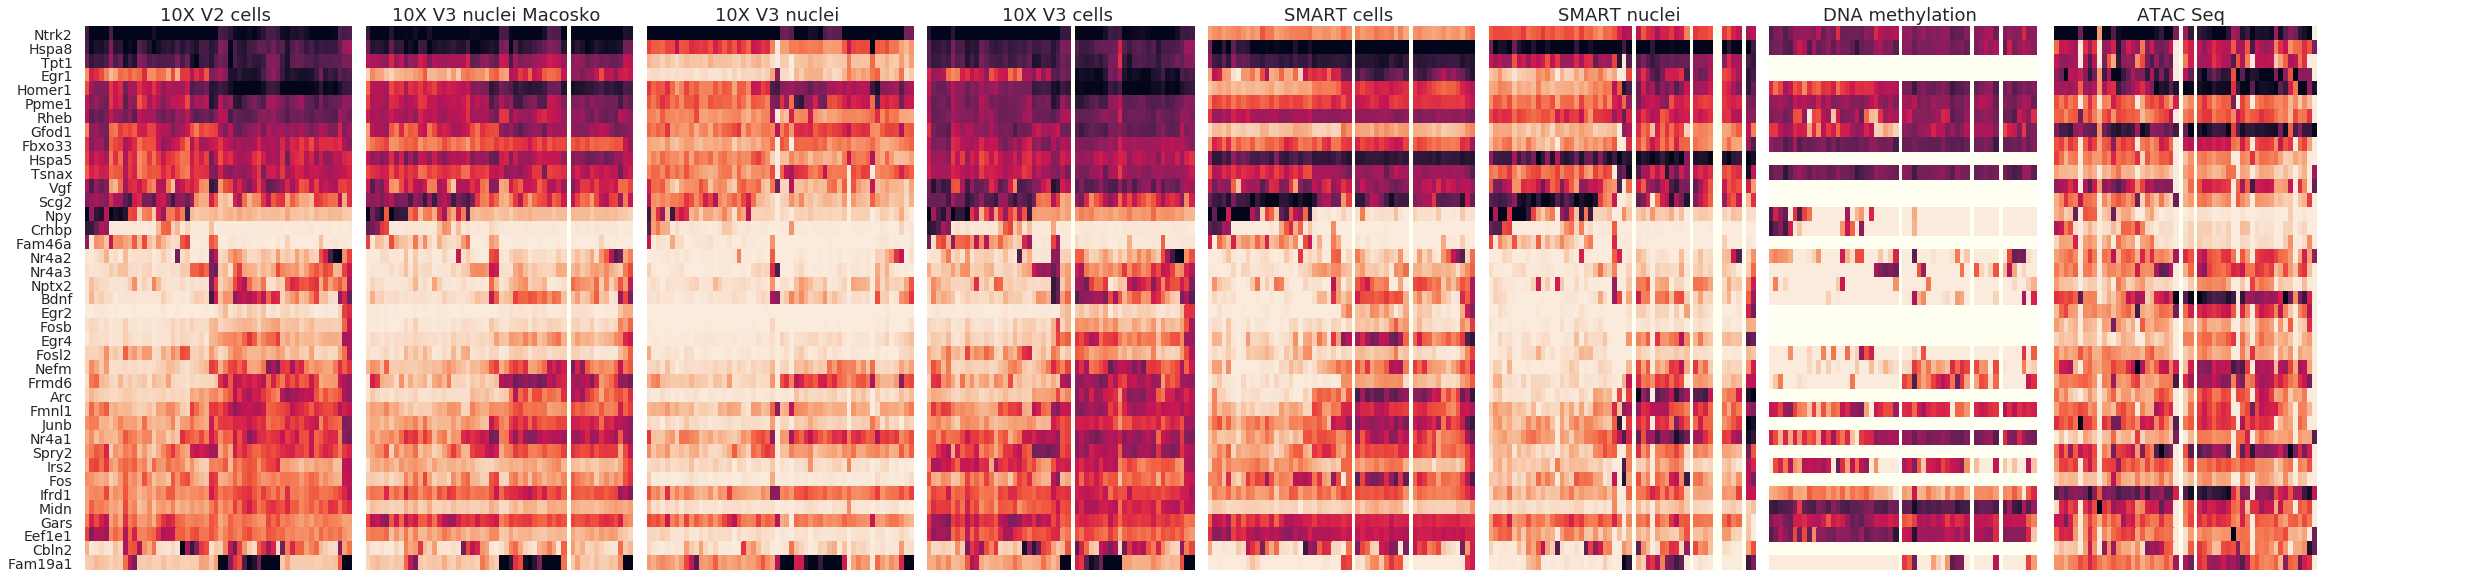

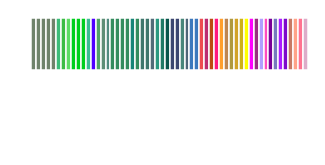

In [58]:
import scipy.cluster.hierarchy as sch
with sns.axes_style('white'):
    n = len(mods_ordered)
    nx = 8
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(5*nx,10*ny))
    axs = axs.flatten()
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', genes_inq[0]
    cbar_ax = fig.add_axes([0.9, 0.2, 0.05, 0.6])
    
    for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
        if i == 0: 
            cbar = False
            
            # row gene
            Z = sch.linkage(df_plots[mod].fillna(0), method='average', metric='euclidean', optimal_ordering=True)
            dn = sch.dendrogram(Z, no_plot=True)['leaves']
            # col clst
            Z = sch.linkage(df_plots[mod].fillna(0).T, method='average', metric='euclidean', optimal_ordering=True)
            dn_clst = sch.dendrogram(Z, no_plot=True)['leaves']
        else:
            cbar = False
            
        if settings[mod].mod_category == 'mc':
            vmin, vmax = -1, 0
        else:
            vmin, vmax = 0, 1
            
        g = sns.heatmap(df_plots[mod]
#                             .iloc[dn, dn_clst],
#                             .loc[genes_inq, :]
#                             [order_joint_sch], 
                            .iloc[dn, :]
#                             [clsts_uniq], 
                            .iloc[:, dn_clst],
                                    ax=ax, 
                                     cbar=cbar,
                                     yticklabels=True,
                                     cbar_ax=cbar_ax,
                                     cmap='rocket_r',
#                                      robust=True,
                                    vmin=vmin,
                                    vmax=vmax,
                                     )
        g.set_facecolor('#fffff2')
        ax.set_title('{} '.format(settings[mod].name, ))
        ax.set_xticks([])
        
        if i == 0:
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
        else:
            ax.set_yticks([])
            
        ax.set_xlabel('')
            
        ax.set_aspect('auto')
        
        for _, spine in ax.spines.items():
            spine.set_color(settings[mod].color)
            spine.set_linewidth(3)
        
    for ax in axs[n:]:
        ax.axis('off')
    cbar_ax.axis('off')
        
    
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.savefig(output_figures.format('round3_7_gene_heatmap_ERG_LRG', 'pdf'), bbox_inches='tight')
    plt.show()
    
# fig, ax_clst = plt.subplots(figsize=(5, 1))
# to_plot = pd.DataFrame()
# to_plot['color'] = joint_annot.loc[clsts_uniq, 'cluster_color']
# to_plot['bar'] = 1
# (to_plot['bar'].plot.bar(stacked=True, width=1, 
#                  alpha=1, 
#                   ax=ax_clst, 
#                   legend=False, 
#                  color=to_plot['color'].values, 
#                  )
# )
# ax_clst.axis('off')
# fig.savefig(output_figures.format('round3_7_gene_heatmap_cluster_color_bars_ERG_LRG', 'pdf'), bbox_inches='tight')
# plt.show()

In [74]:
clsts_manual_order_section = collections.OrderedDict({ 
    'L2/3 IT': collections.OrderedDict({
      '4-1-1': 'L2/3 IT ',
      '4-1-2': 'L2/3 IT ',
      '4-2-1': 'L2/3 IT ',
      '4-2-2': 'L2/3 IT ',
      '4-2-3': 'L2/3 IT ',
    }), 
    
    'L5 IT': collections.OrderedDict({
      '1-1-1': 'L5 IT Rspo1_1',
      '1-2-1': 'L5 IT Rspo2_1',
      '1-2-2': 'L5 IT Tcap_1',
      '3-1-2': 'L5 IT S100b',
      '3-2-1': 'L5 IT S100b',
      '3-2-2': 'L5 IT S100b',
    }), 
    
    'L6 IT': collections.OrderedDict({
      '3-1-1': 'L6 IT_2',
      '3-3-1': 'L6 IT Car3',
    }), 
    
    'L5 ET': collections.OrderedDict({
      '9-1-1': 'L5 ET_1',
      '9-2-1': 'L5 ET_2',
      '9-2-2': 'L5 ET_3',
    }), 
    
    'L6 CT': collections.OrderedDict({
      '2-1-1': 'L6 CT Cpa6',
      '2-1-2': 'L6 CT Cpa6',
      '2-2-1': 'L6 CT Cpa6',
      '2-2-2': 'L6 CT Cpa6',
      '2-2-3': 'L6 CT Gpr139',
      '2-2-4': 'L6 CT Cpa6',
      '2-3-1': 'L6 CT Nxph2 Pou3f2',
      '2-3-2': 'L6 CT Nxph2 Pou3f2',
      '2-3-3': 'L6 CT Nxph2 Kit',
    }), 
    
    'L6b': collections.OrderedDict({
      '8-1-1': 'L6b Shisa6_1',
      '8-1-2': 'L6b Shisa6_2_2',
      '8-2-1': 'L6b Ror1',
      '8-3-1': 'L6b Kcnip1_2',
      '8-3-2': 'L6b Kcnip1_2',
    }), 
    
    'L6 NP': collections.OrderedDict({
      '7-1-1': 'L6 NP Trh_1',
      '7-1-2': 'L5 NP Trh',
      '7-2-1': 'L5 NP Slc17a8',
      '7-2-2': 'L5 NP Slc17a8',
    }), 
    
    'Pvalb': collections.OrderedDict({
      '5-4-1': 'Pvalb Gabrg1',
      '5-1-1': 'Pvalb Reln',
      '5-1-2': 'Pvalb Calb1_1',
      '5-5-1': 'Pvalb Vipr2',
    }), 
    
    'Sst': collections.OrderedDict({
      '5-2-1': 'Sst Myh8_2',
      '5-2-2': 'Sst Crhr2_1',
      '5-2-3': 'Sst Crhr2_2',
      '5-3-1': 'Sst Calb2',
      '5-3-2': 'Sst Hspe_3',
      '10-1-1': 'Sst Chodl',
    }), 
    
    'Vip': collections.OrderedDict({
      '6-1-1': 'Vip Chat',
      '6-1-2': 'Vip Crispld2',
      '6-3-1': 'Vip Gpc3',
      '6-3-2': 'Vip Htr1f_1',
      '6-5-3': 'Sncg Npy2r',
      '6-3-3': 'Vip Igfbp6',
      '6-5-2': 'Vip Serpinf1_2',
      '6-5-1': 'Sncg Col14a1',
    }), 
    
    'Lamp5': collections.OrderedDict({
      '6-6-1': 'Lamp5 Lhx6',
      '6-2-1': 'Lamp5 Slc35d3',
      '6-4-1': 'Lamp5 Pdlim5',
      '6-4-2': 'Lamp5 Pax6',
    }), 
})
    
clsts_uniqs = collections.OrderedDict({_class: np.array(list(clsts_manual_order_section[_class].keys())) 
                               for _class in clsts_manual_order_section.keys()})

print(clsts_uniqs)

OrderedDict([('L2/3 IT', array(['4-1-1', '4-1-2', '4-2-1', '4-2-2', '4-2-3'], dtype='<U5')), ('L5 IT', array(['1-1-1', '1-2-1', '1-2-2', '3-1-2', '3-2-1', '3-2-2'], dtype='<U5')), ('L6 IT', array(['3-1-1', '3-3-1'], dtype='<U5')), ('L5 ET', array(['9-1-1', '9-2-1', '9-2-2'], dtype='<U5')), ('L6 CT', array(['2-1-1', '2-1-2', '2-2-1', '2-2-2', '2-2-3', '2-2-4', '2-3-1',
       '2-3-2', '2-3-3'], dtype='<U5')), ('L6b', array(['8-1-1', '8-1-2', '8-2-1', '8-3-1', '8-3-2'], dtype='<U5')), ('L6 NP', array(['7-1-1', '7-1-2', '7-2-1', '7-2-2'], dtype='<U5')), ('Pvalb', array(['5-4-1', '5-1-1', '5-1-2', '5-5-1'], dtype='<U5')), ('Sst', array(['5-2-1', '5-2-2', '5-2-3', '5-3-1', '5-3-2', '10-1-1'], dtype='<U6')), ('Vip', array(['6-1-1', '6-1-2', '6-3-1', '6-3-2', '6-5-3', '6-3-3', '6-5-2',
       '6-5-1'], dtype='<U5')), ('Lamp5', array(['6-6-1', '6-2-1', '6-4-1', '6-4-2'], dtype='<U5'))])


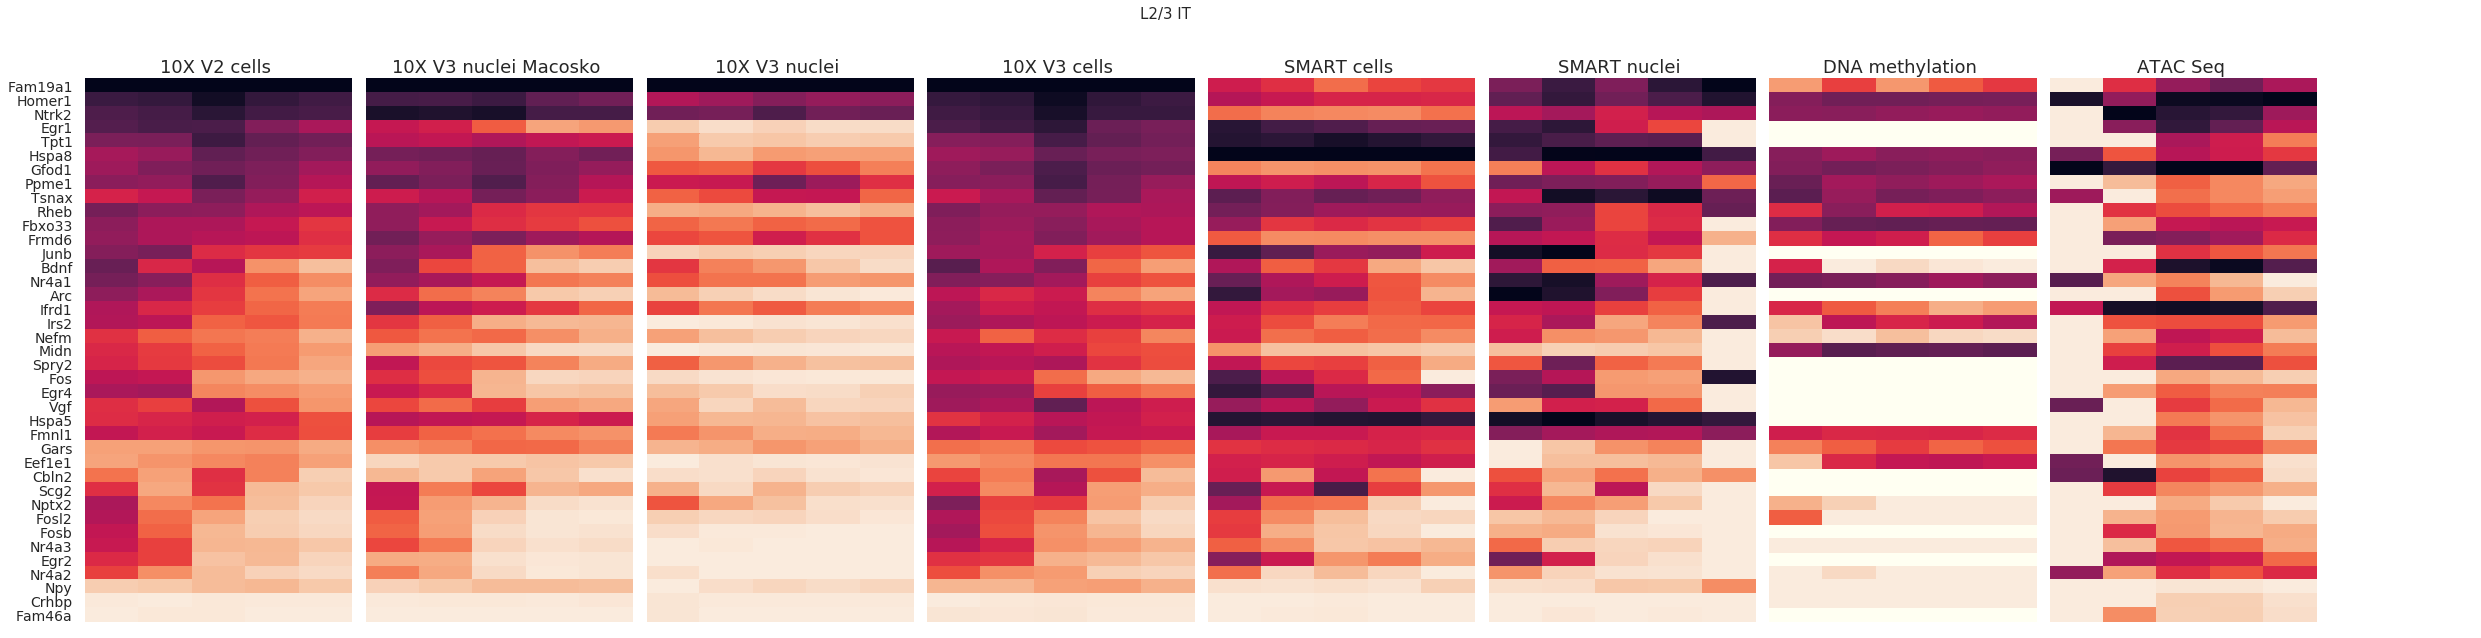

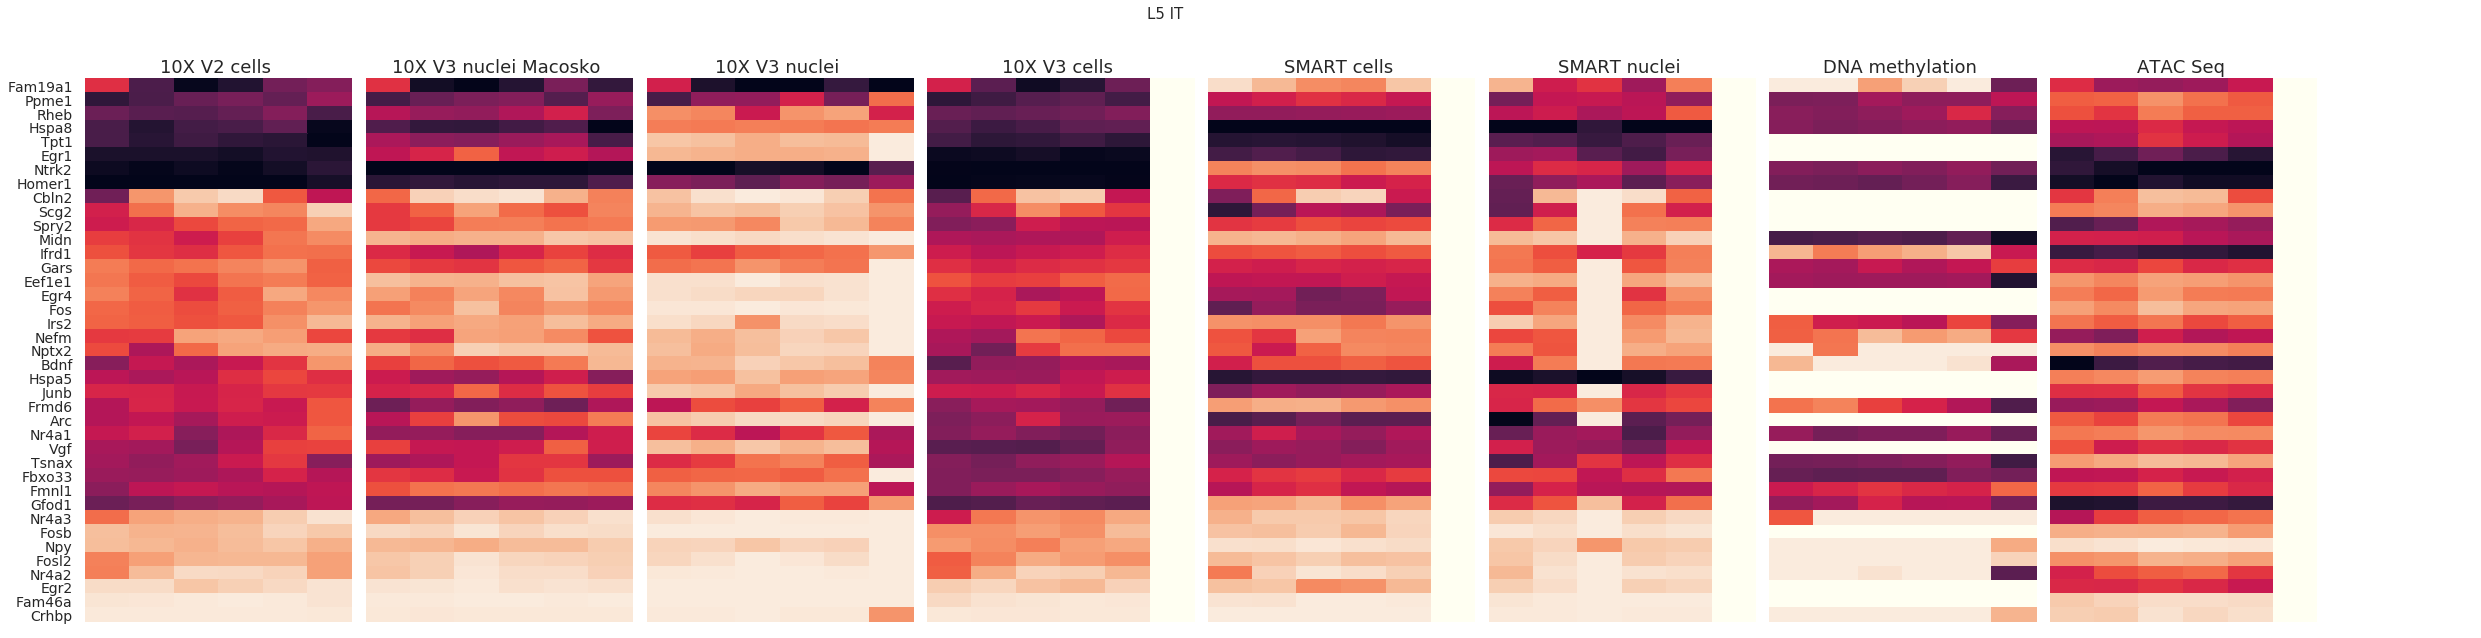

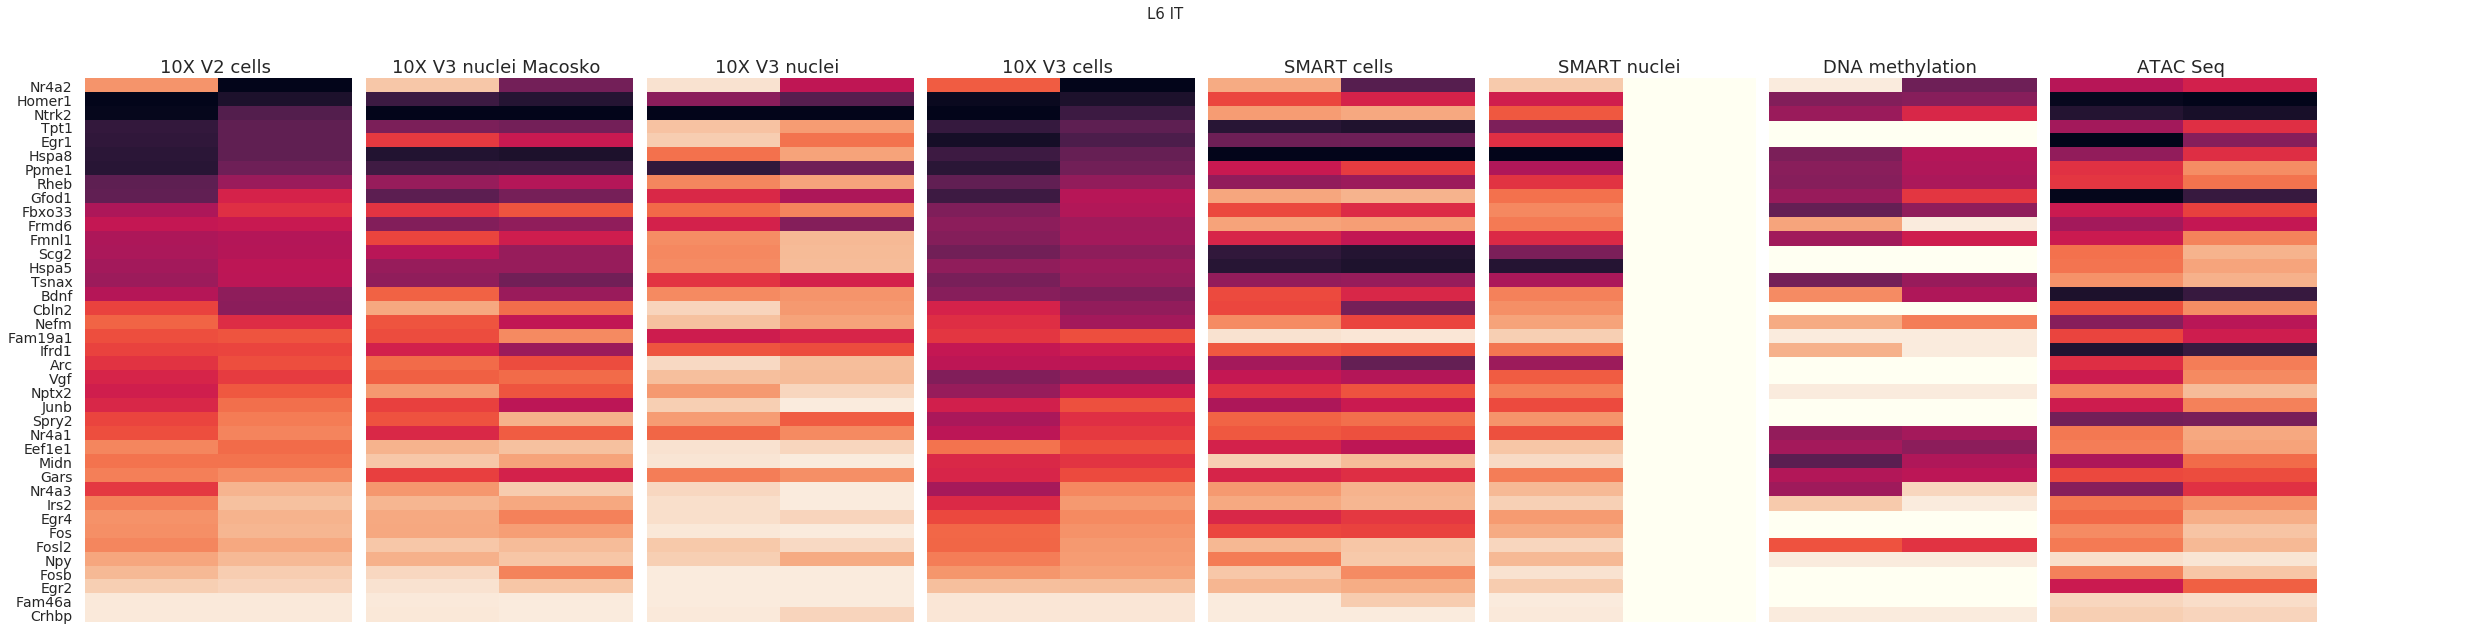

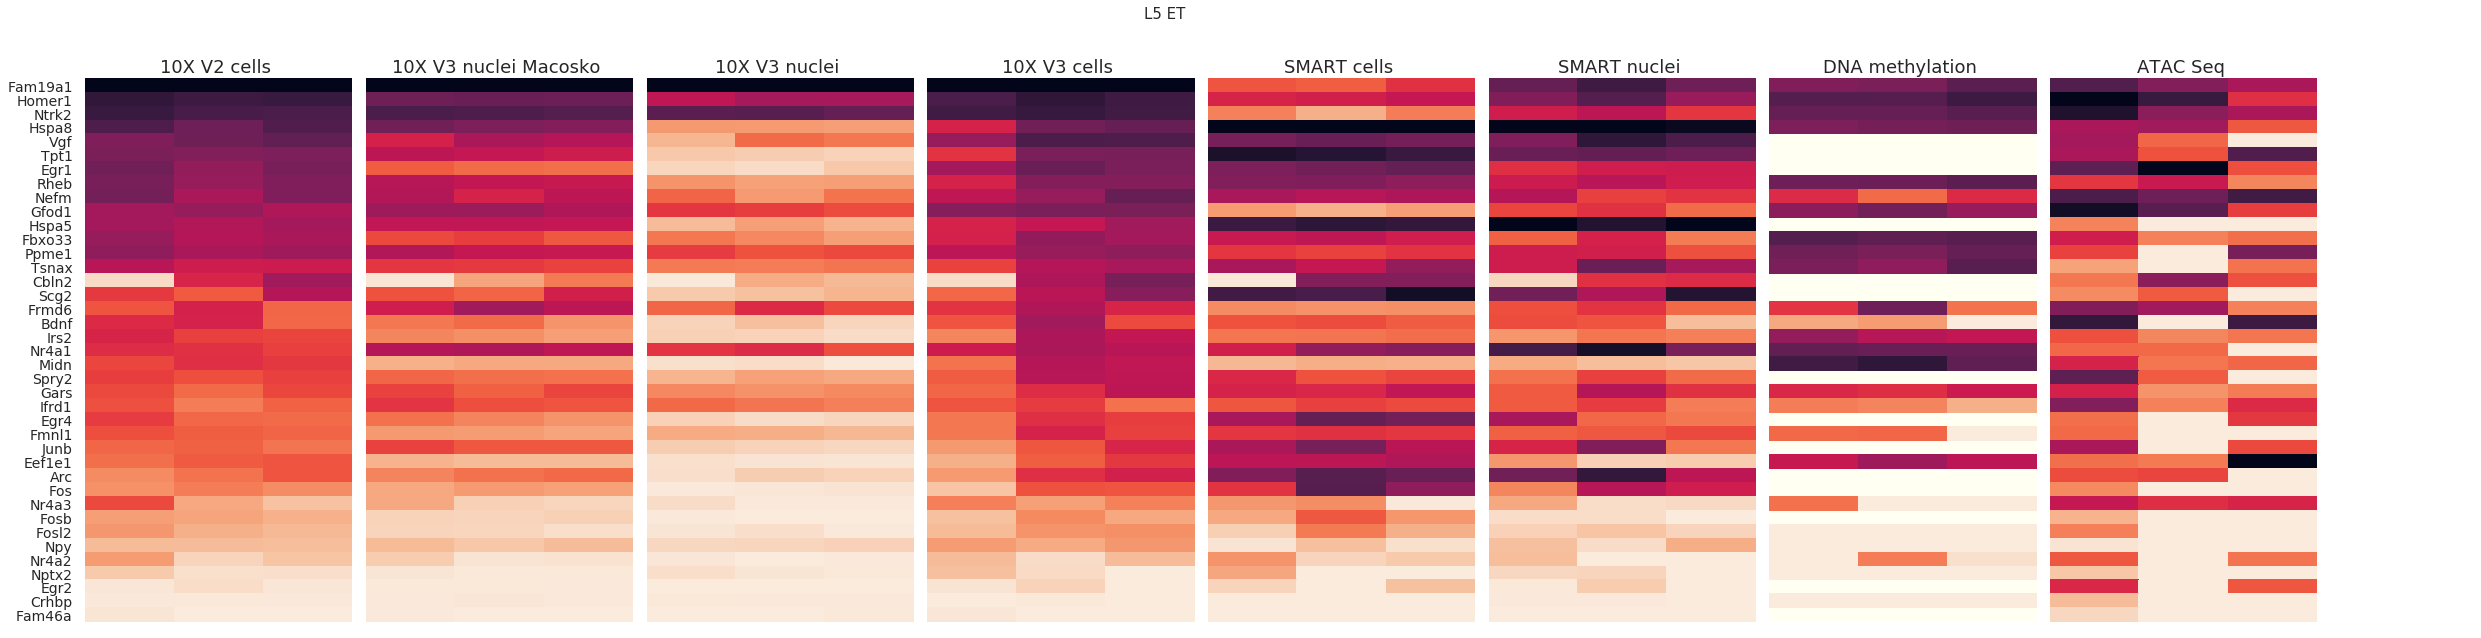

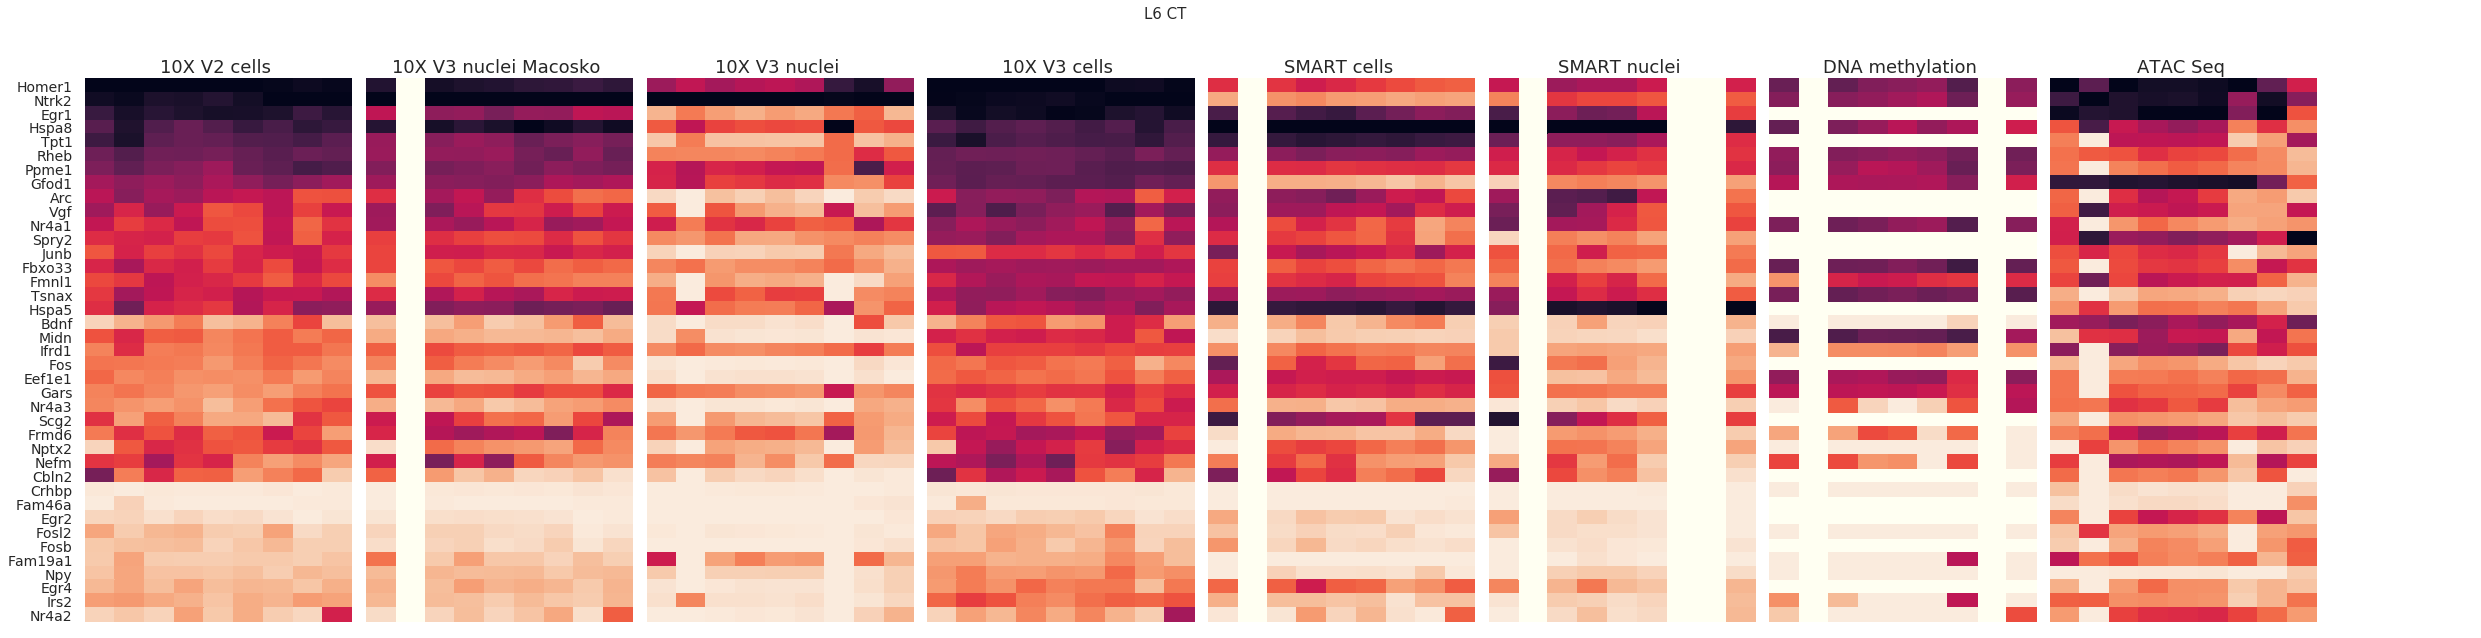

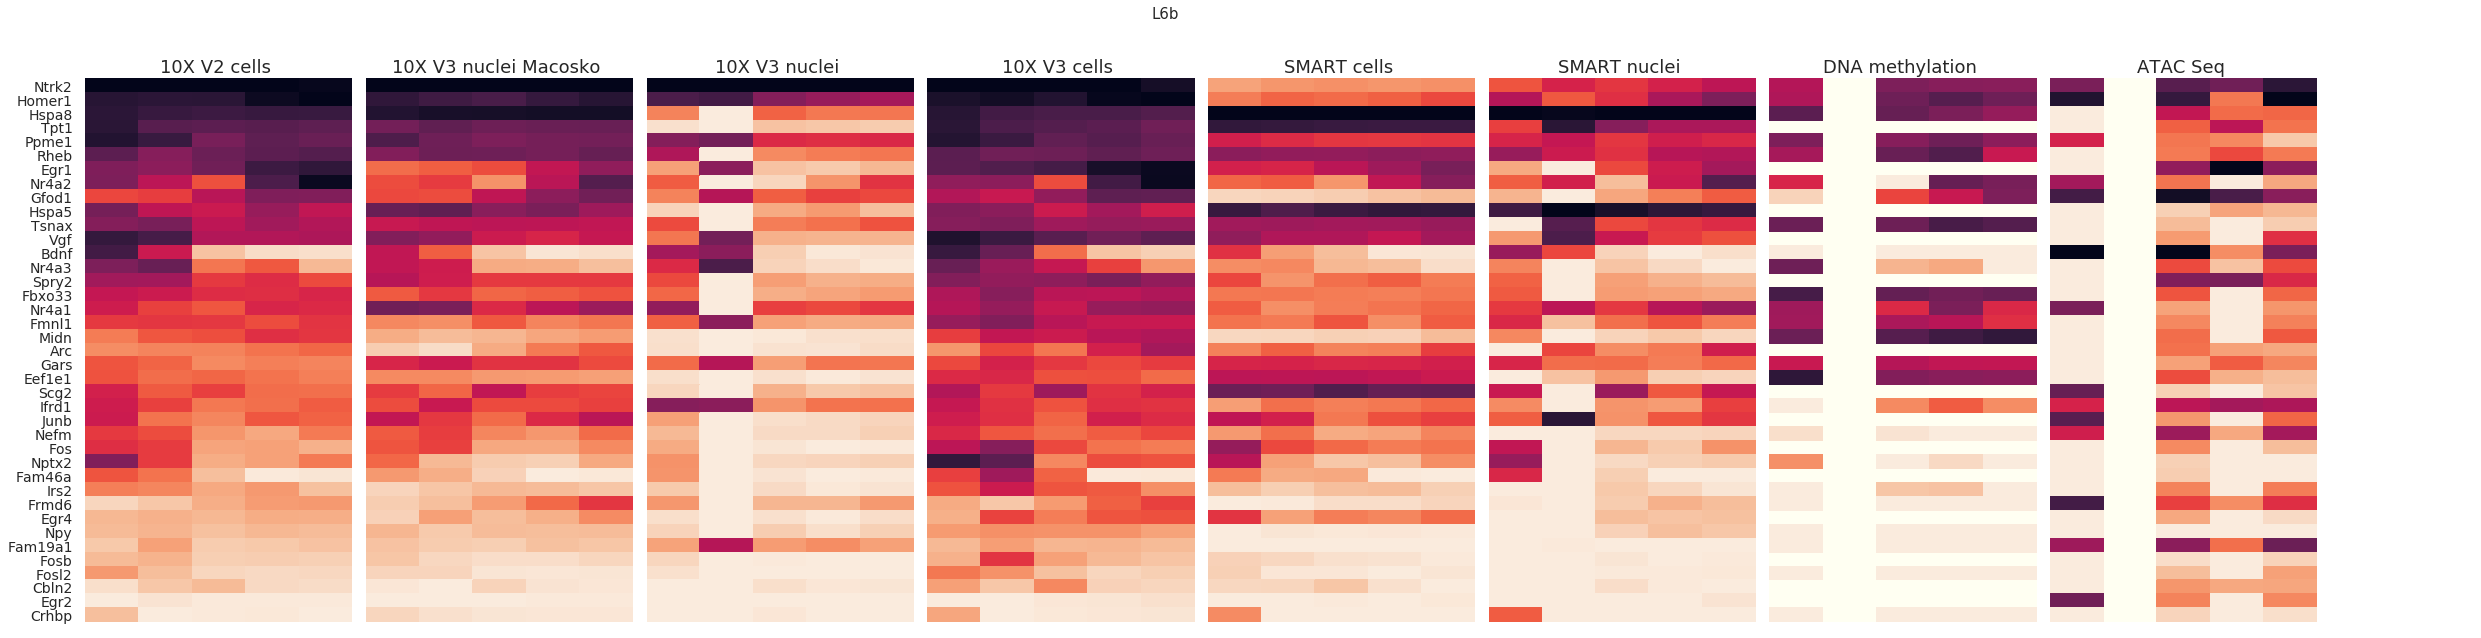

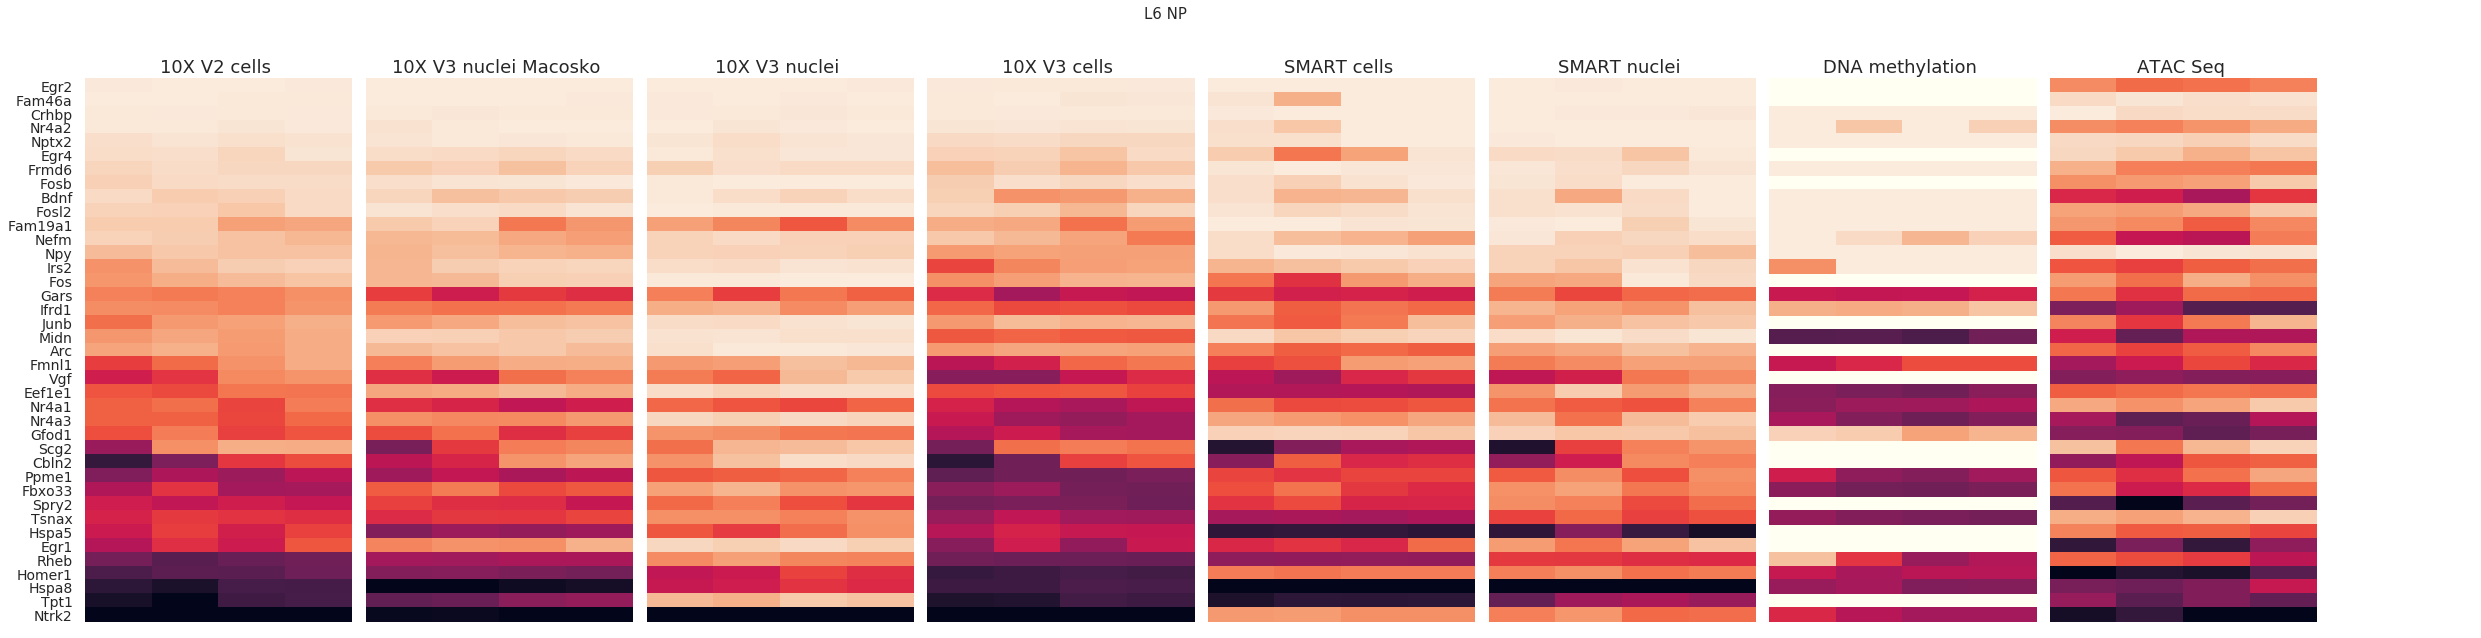

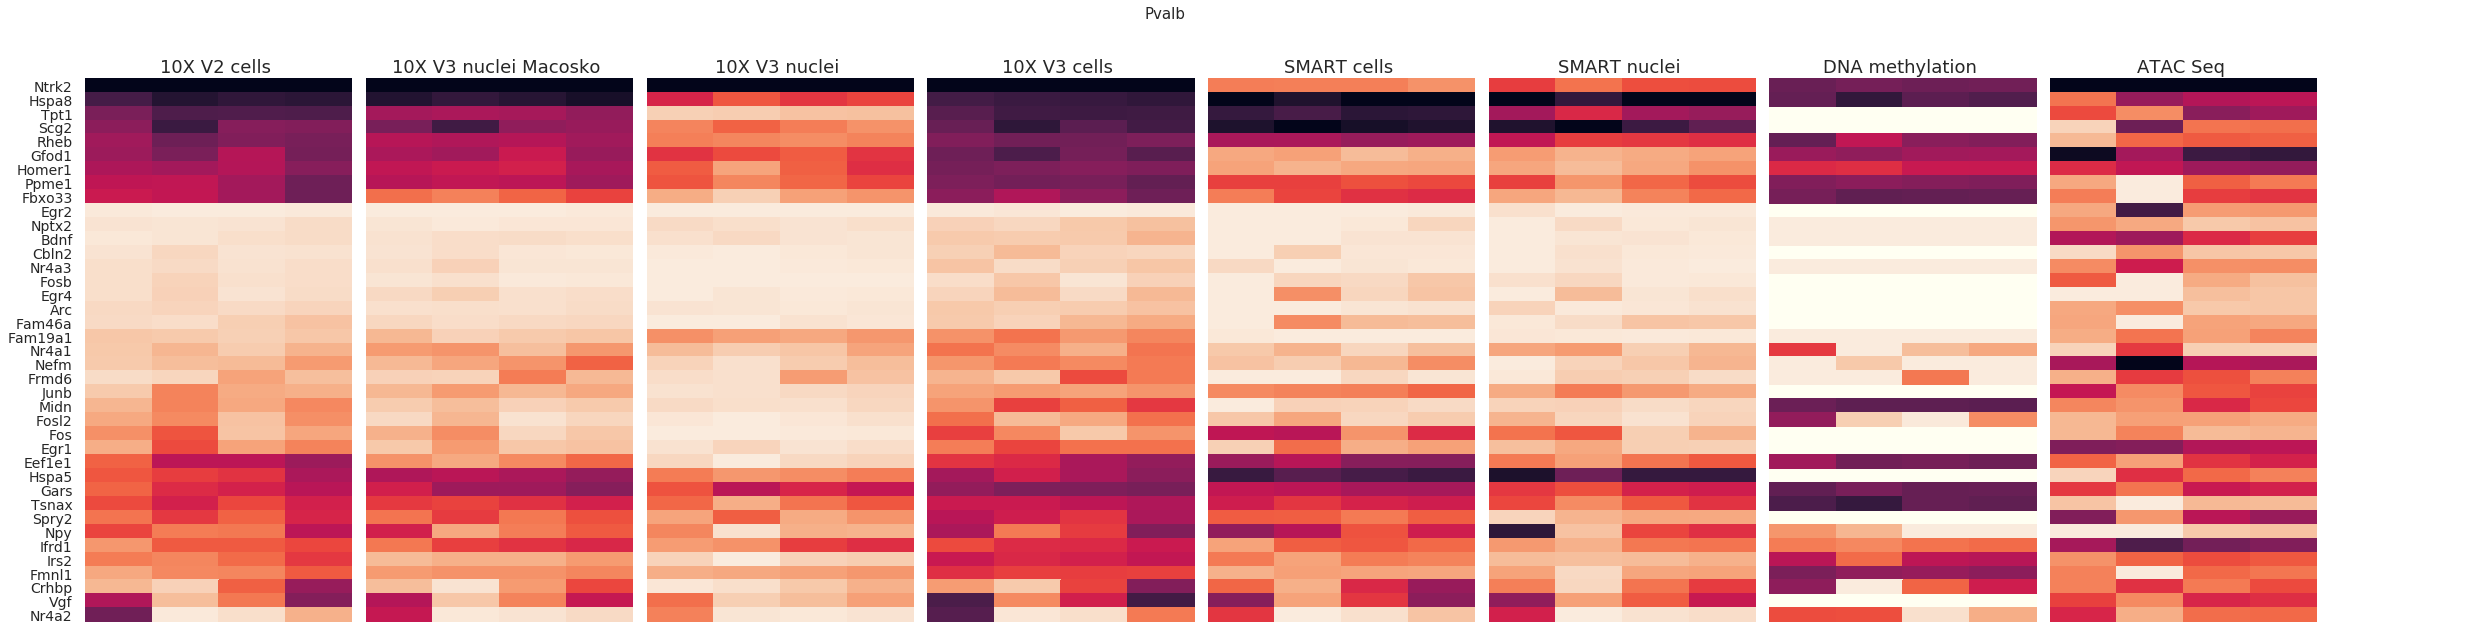

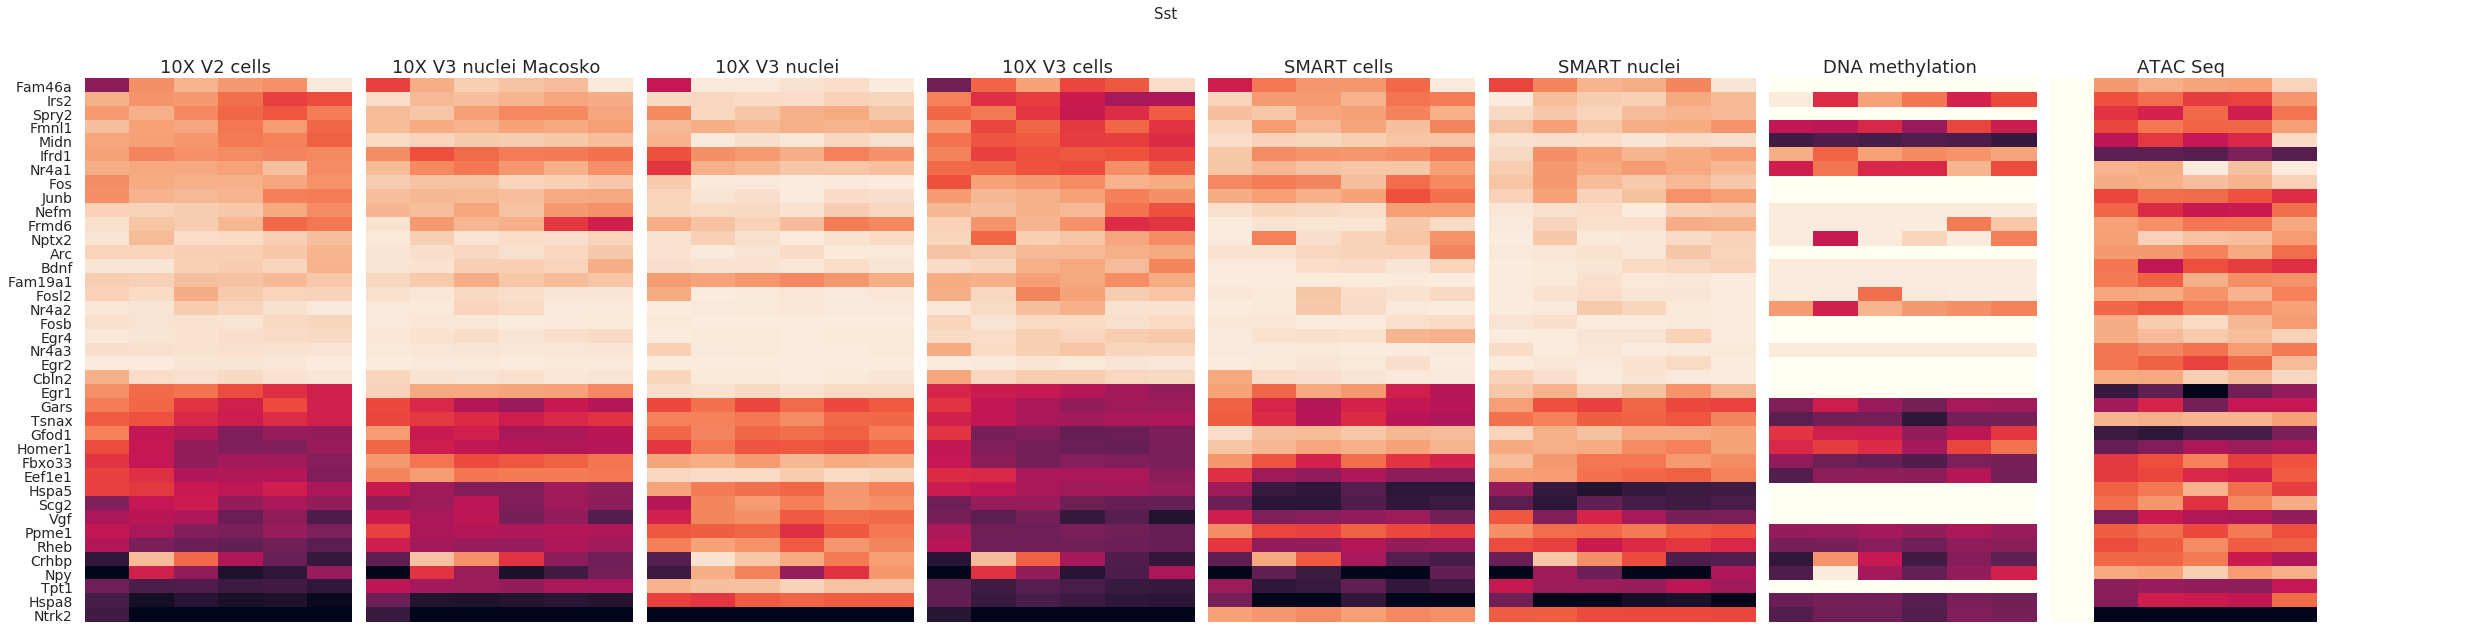

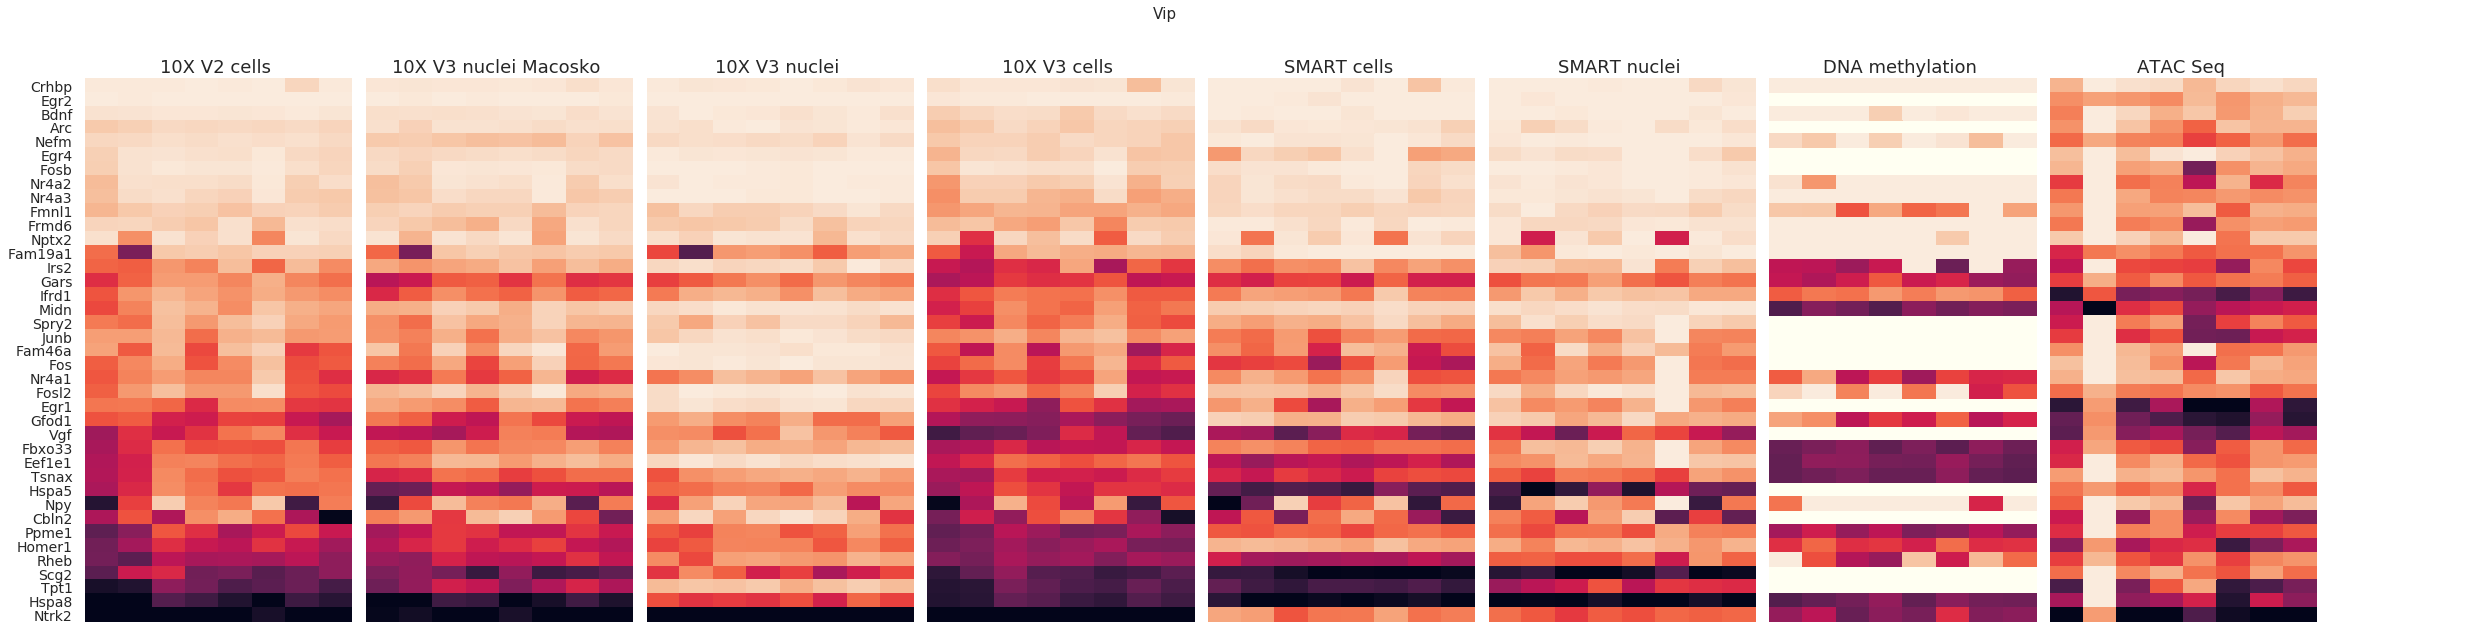

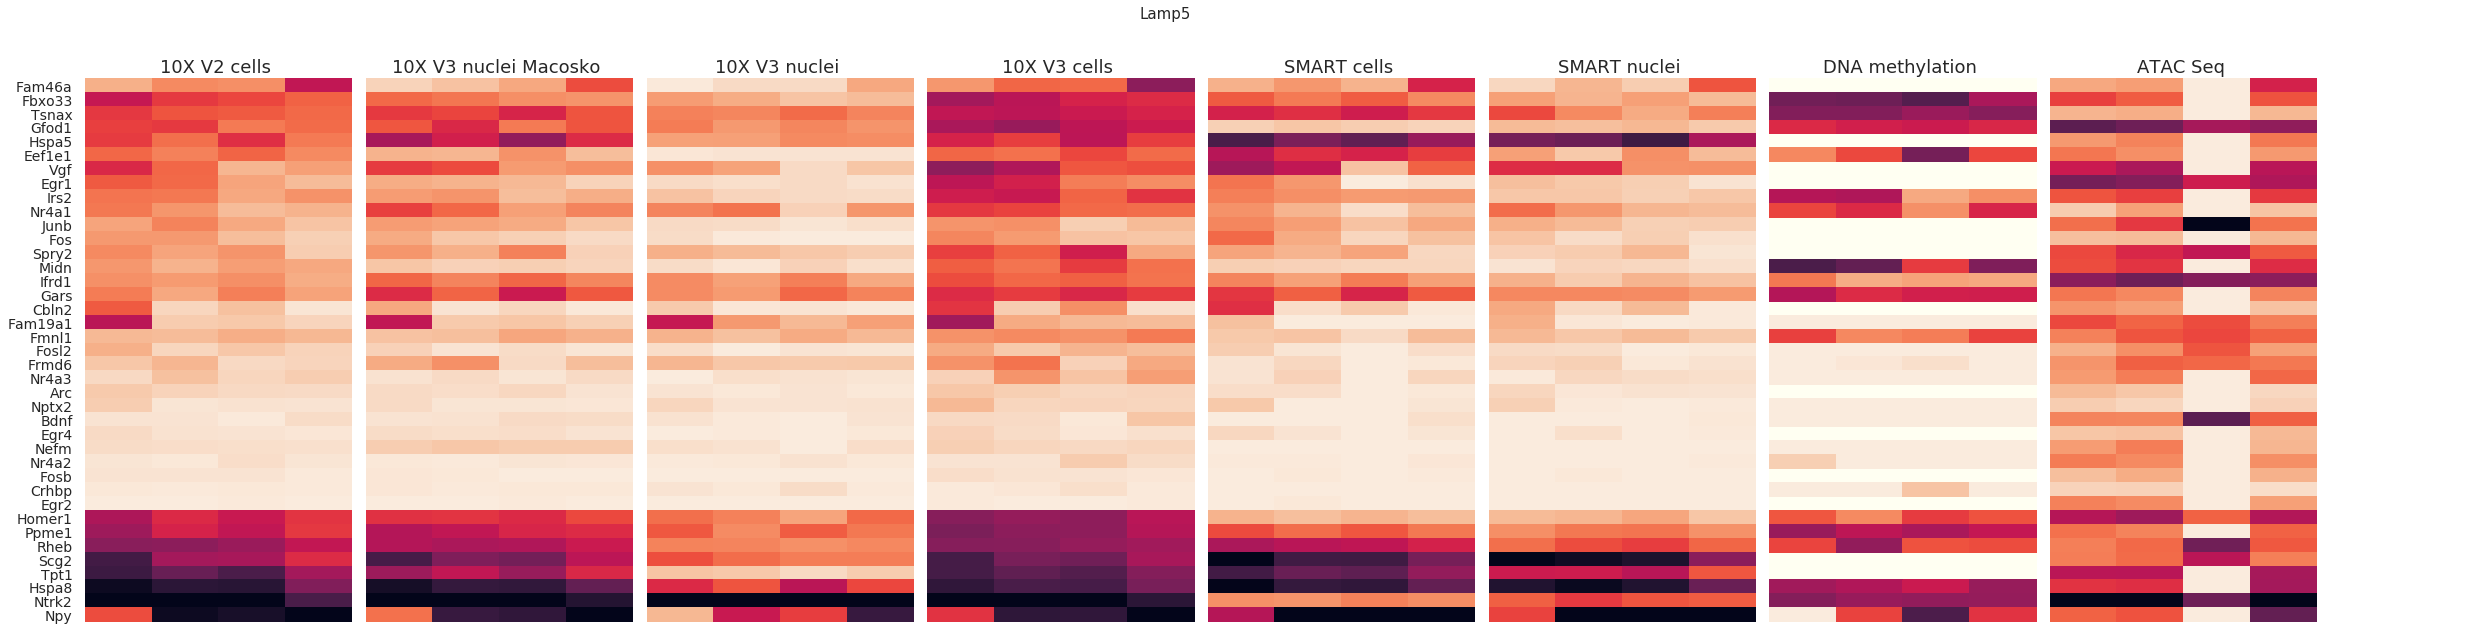

In [94]:
for _class, _clsts_uniq in clsts_uniqs.items():
    with sns.axes_style('white'):
        n = len(mods_ordered)
        nx = 8
        ny = int((n+nx-1)/nx)
        fig, axs = plt.subplots(ny, nx, figsize=(5*nx,10*ny))
        axs = axs.flatten()
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', genes_inq[0]
        cbar_ax = fig.add_axes([0.9, 0.2, 0.05, 0.6])

        for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
            if i == 0: 
                cbar = False

                # row gene
                Z = sch.linkage(df_plots[mod][_clsts_uniq].fillna(0), method='average', metric='euclidean', optimal_ordering=True)
                dn = sch.dendrogram(Z, no_plot=True)['leaves']
                # col clst
                Z = sch.linkage(df_plots[mod][_clsts_uniq].fillna(0).T, method='average', metric='euclidean', optimal_ordering=True)
                dn_clst = sch.dendrogram(Z, no_plot=True)['leaves']
            else:
                cbar = False

            if settings[mod].mod_category == 'mc':
                vmin, vmax = -1, 0
            else:
                vmin, vmax = 0, 1

            g = sns.heatmap(df_plots[mod][_clsts_uniq]
                                .iloc[dn, dn_clst],
#                                 .loc[genes_inq, :]
    #                             [order_joint_sch], 
    #                             .iloc[dn, :]
#                                 [_clsts_uniq], 
    #                             .iloc[:, dn_clst],
                                        ax=ax, 
                                         cbar=cbar,
                                         yticklabels=True,
                                         cbar_ax=cbar_ax,
                                         cmap='rocket_r',
    #                                      robust=True,
                                        vmin=vmin,
                                        vmax=vmax,
                                         )
            g.set_facecolor('#fffff2')
            ax.set_title('{} '.format(settings[mod].name, ))
            ax.set_xticks([])

            if i == 0:
                ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
            else:
                ax.set_yticks([])

            ax.set_xlabel('')

            ax.set_aspect('auto')

            for _, spine in ax.spines.items():
                spine.set_color(settings[mod].color)
                spine.set_linewidth(3)

        for ax in axs[n:]:
            ax.axis('off')
        cbar_ax.axis('off')


        fig.suptitle(_class, fontsize=15)
        fig.subplots_adjust(hspace=0.05, wspace=0.05)
        fig.savefig(output_figures.format('round3_7_gene_heatmap_EGR_LGR_{}'.format(_class.replace(' ', '_').replace('/', '_')), 'pdf'), bbox_inches='tight')
        plt.show()


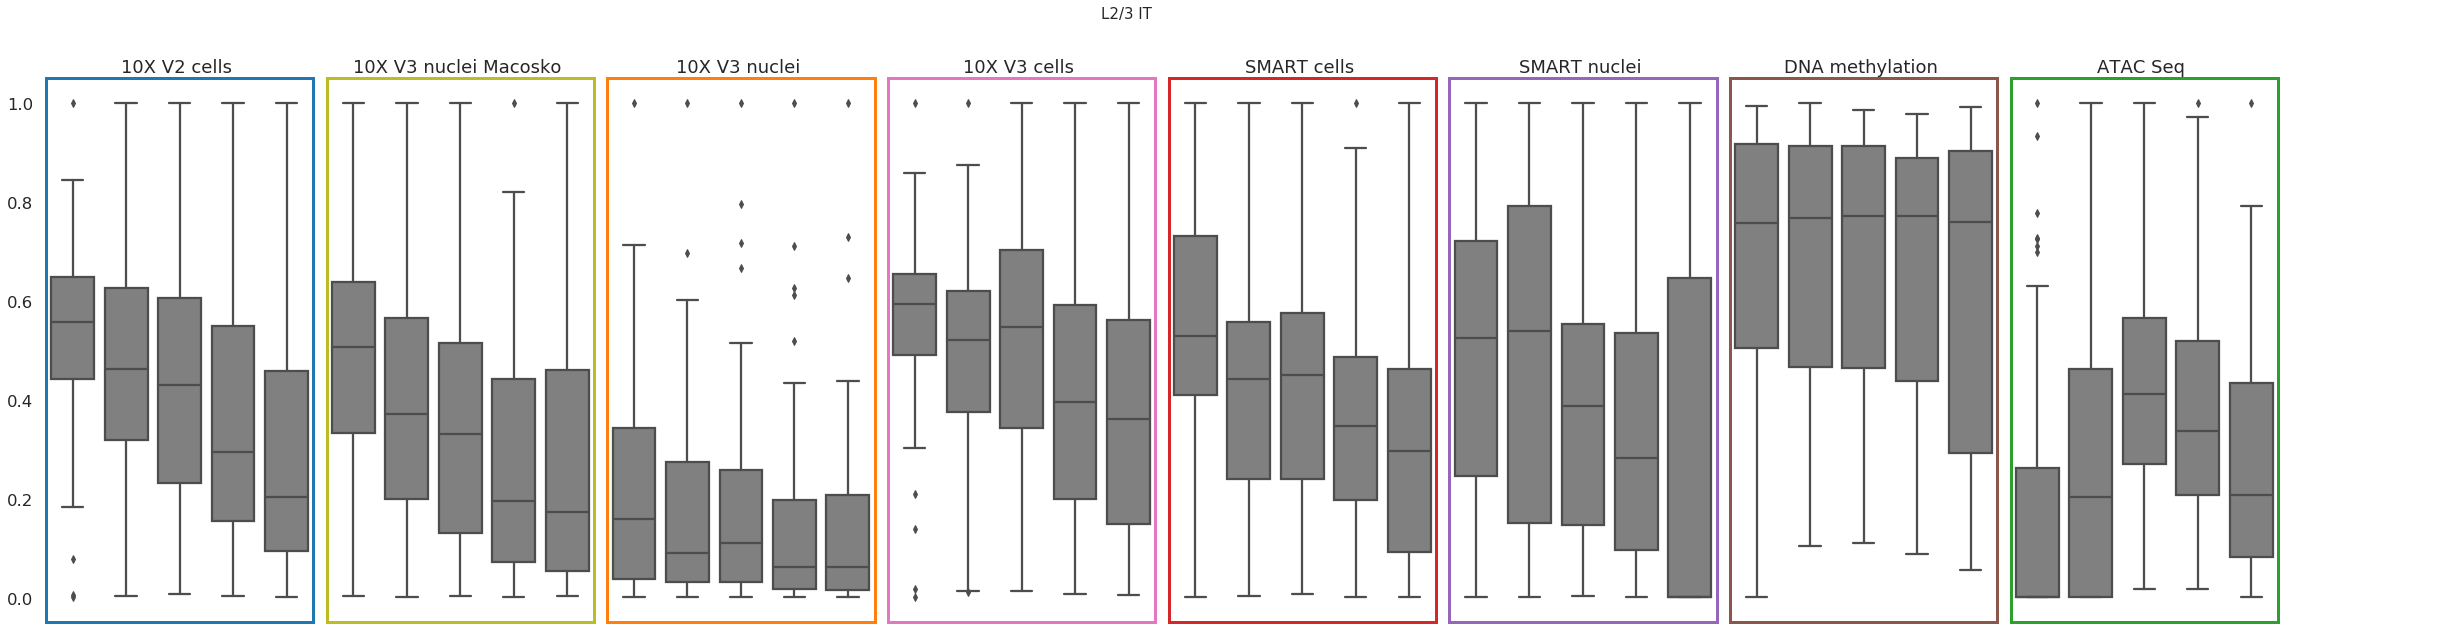

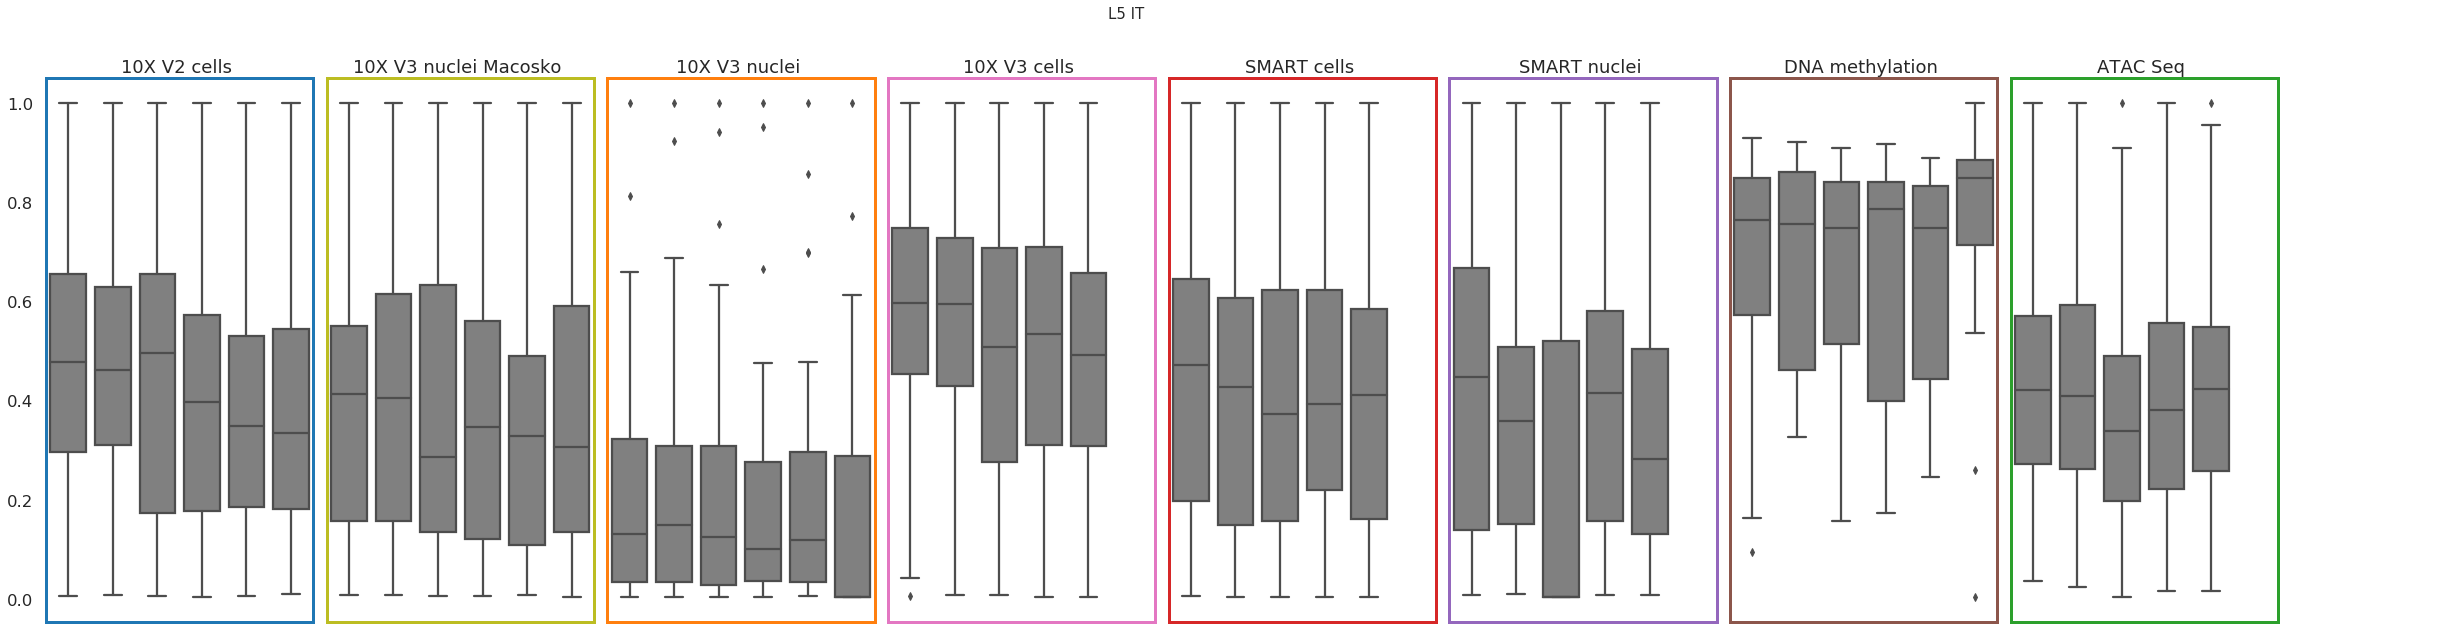

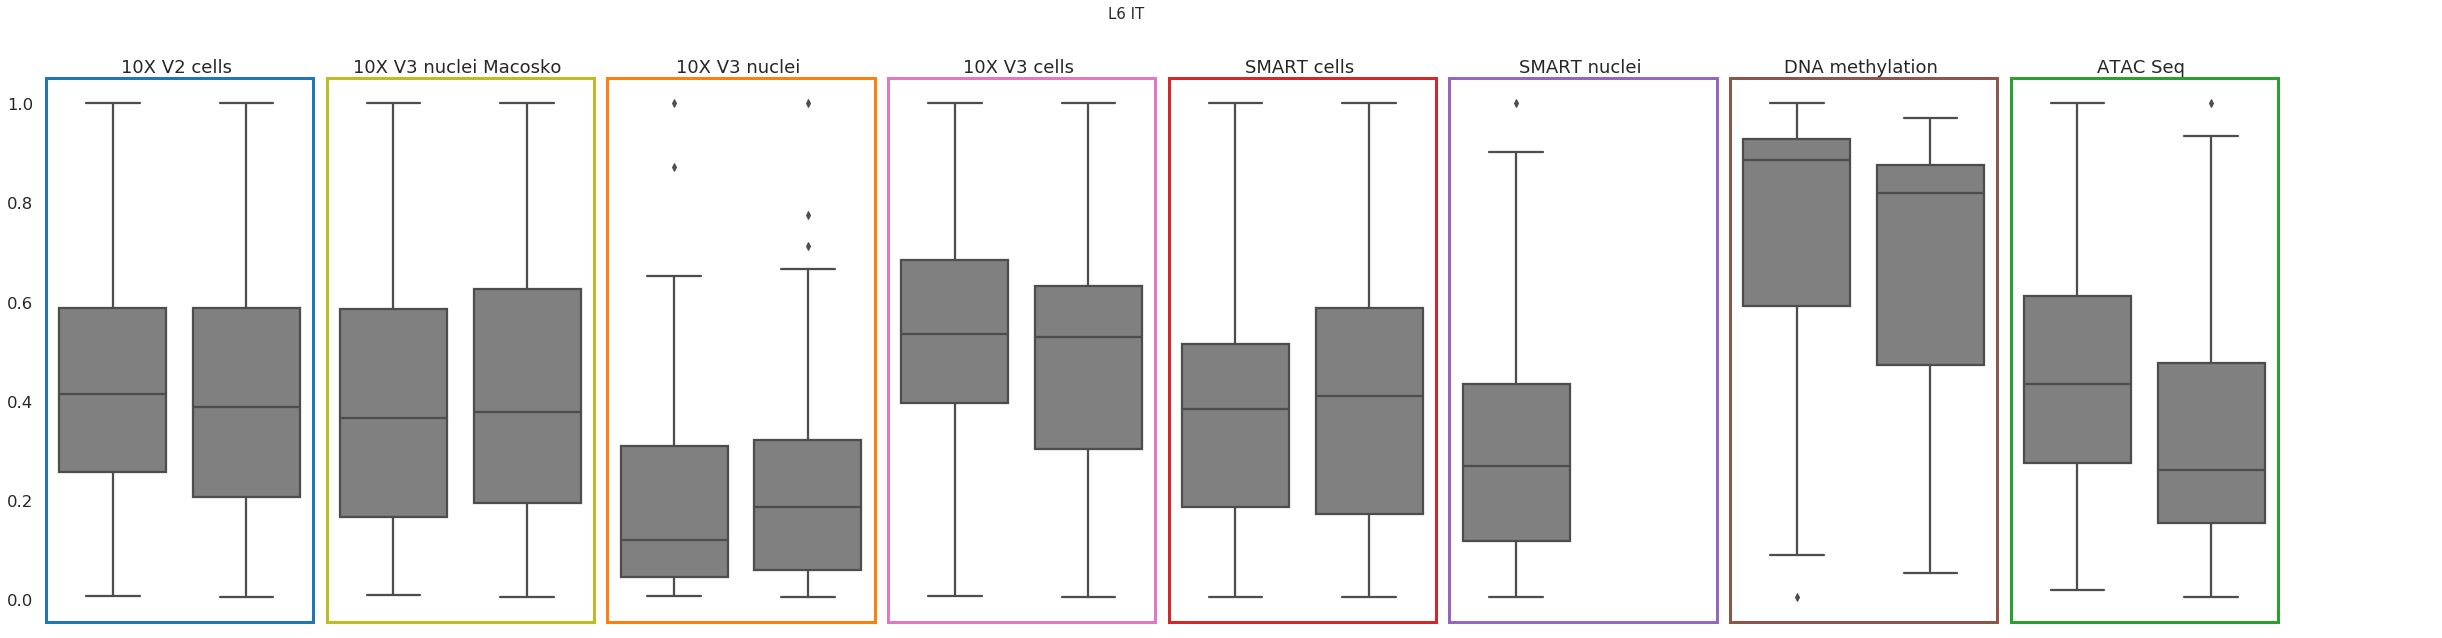

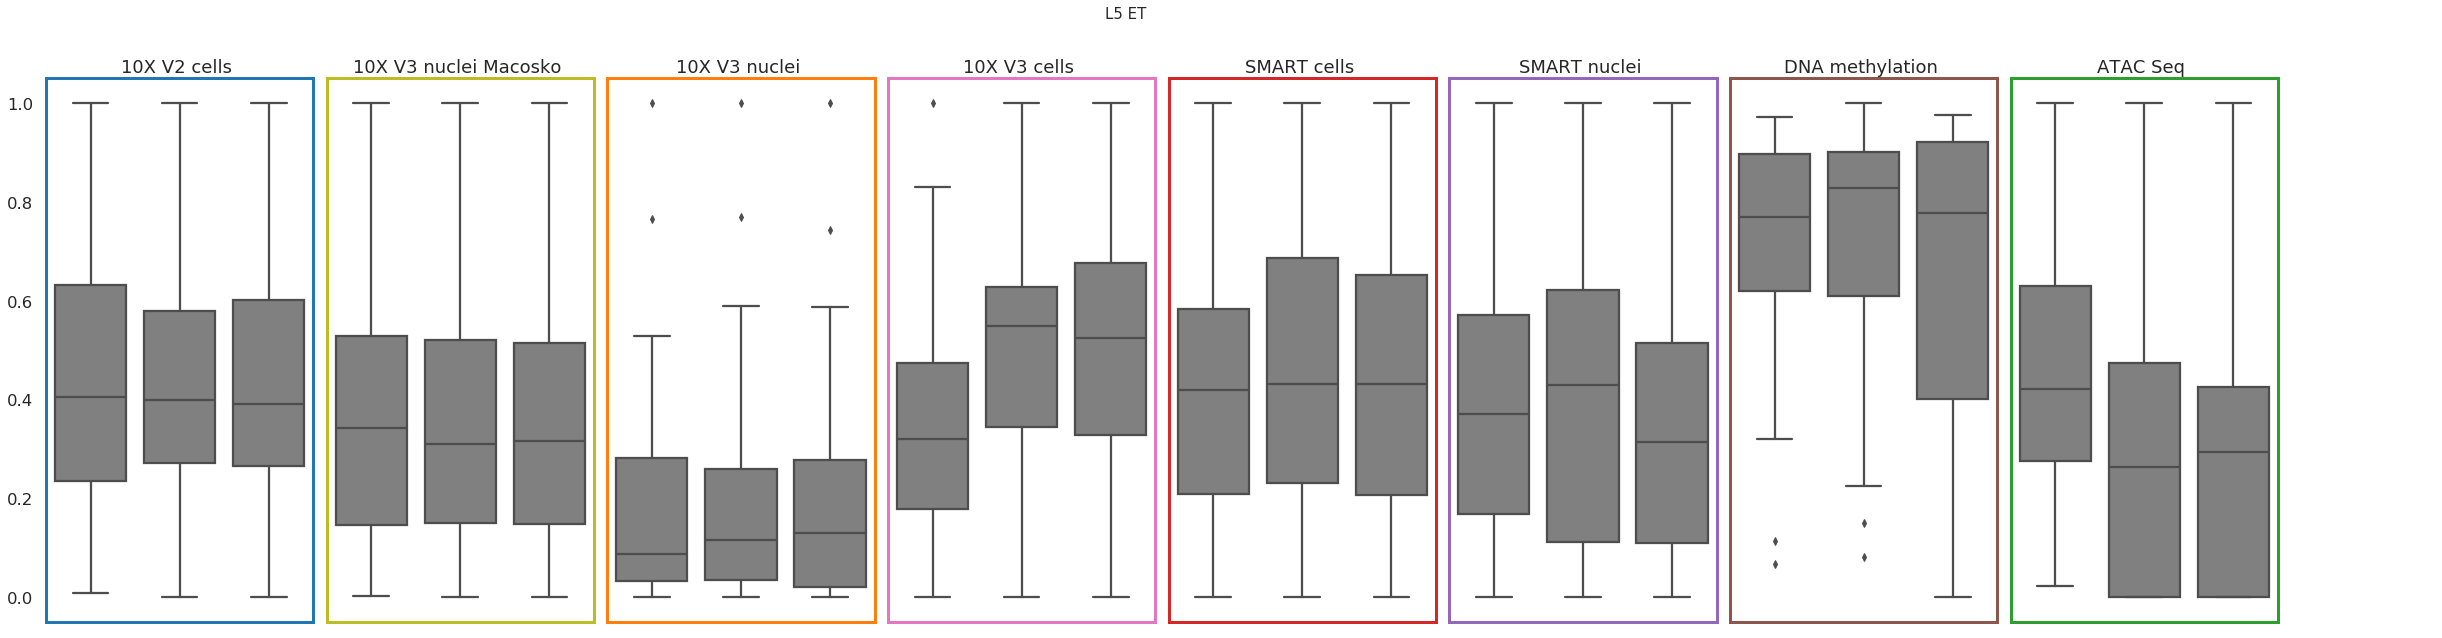

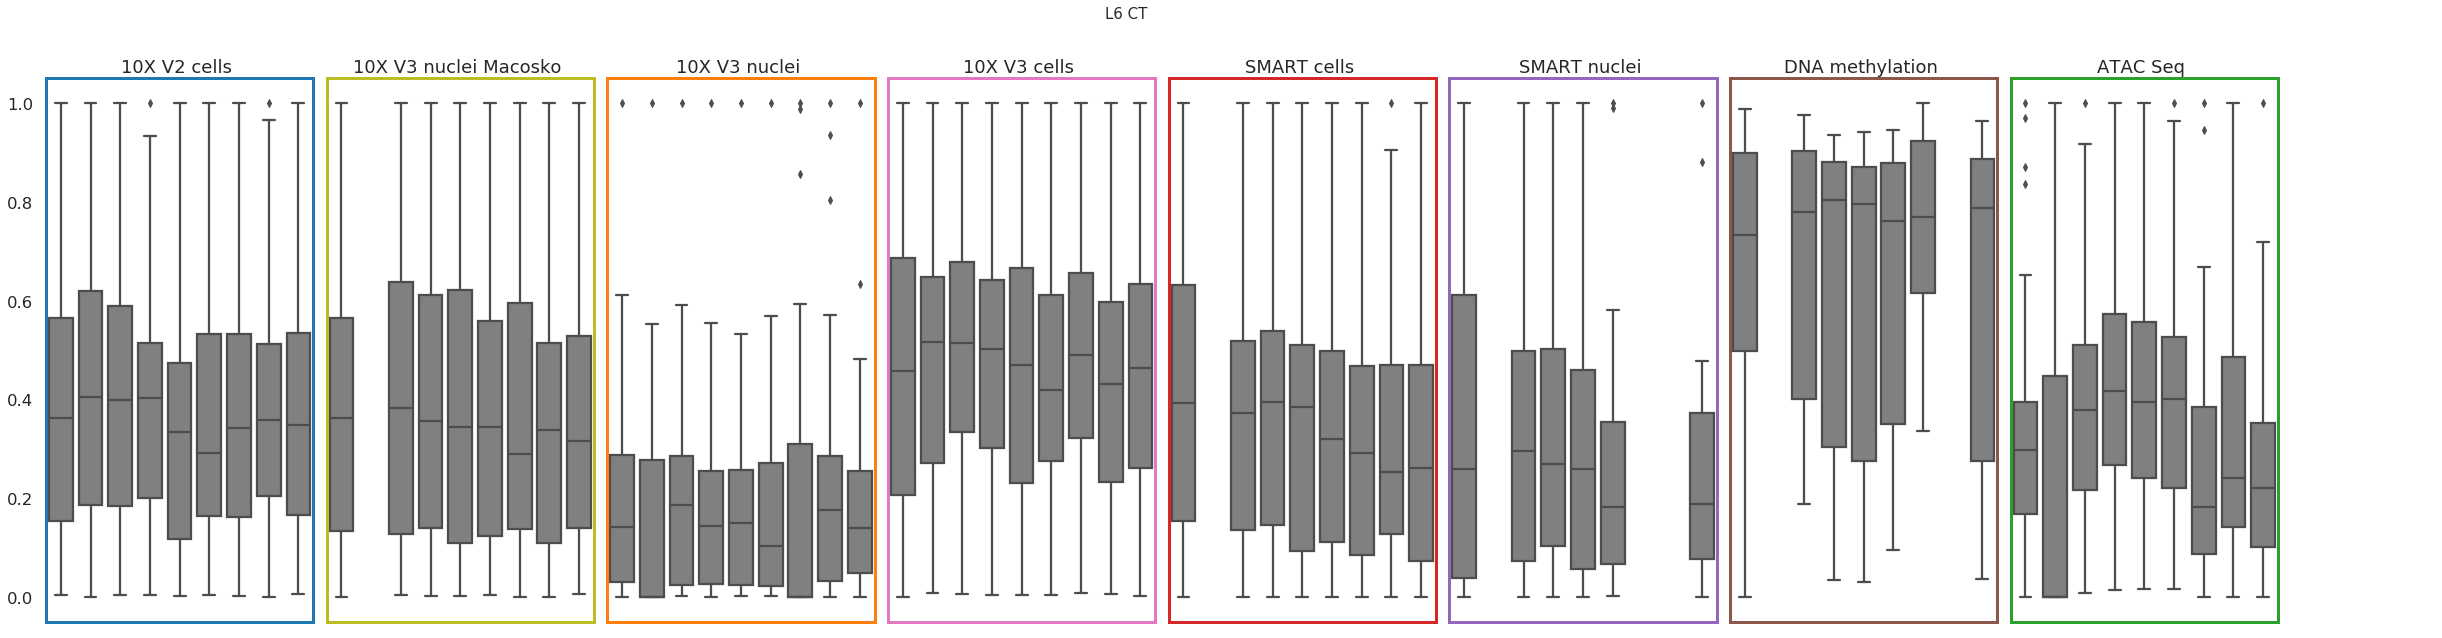

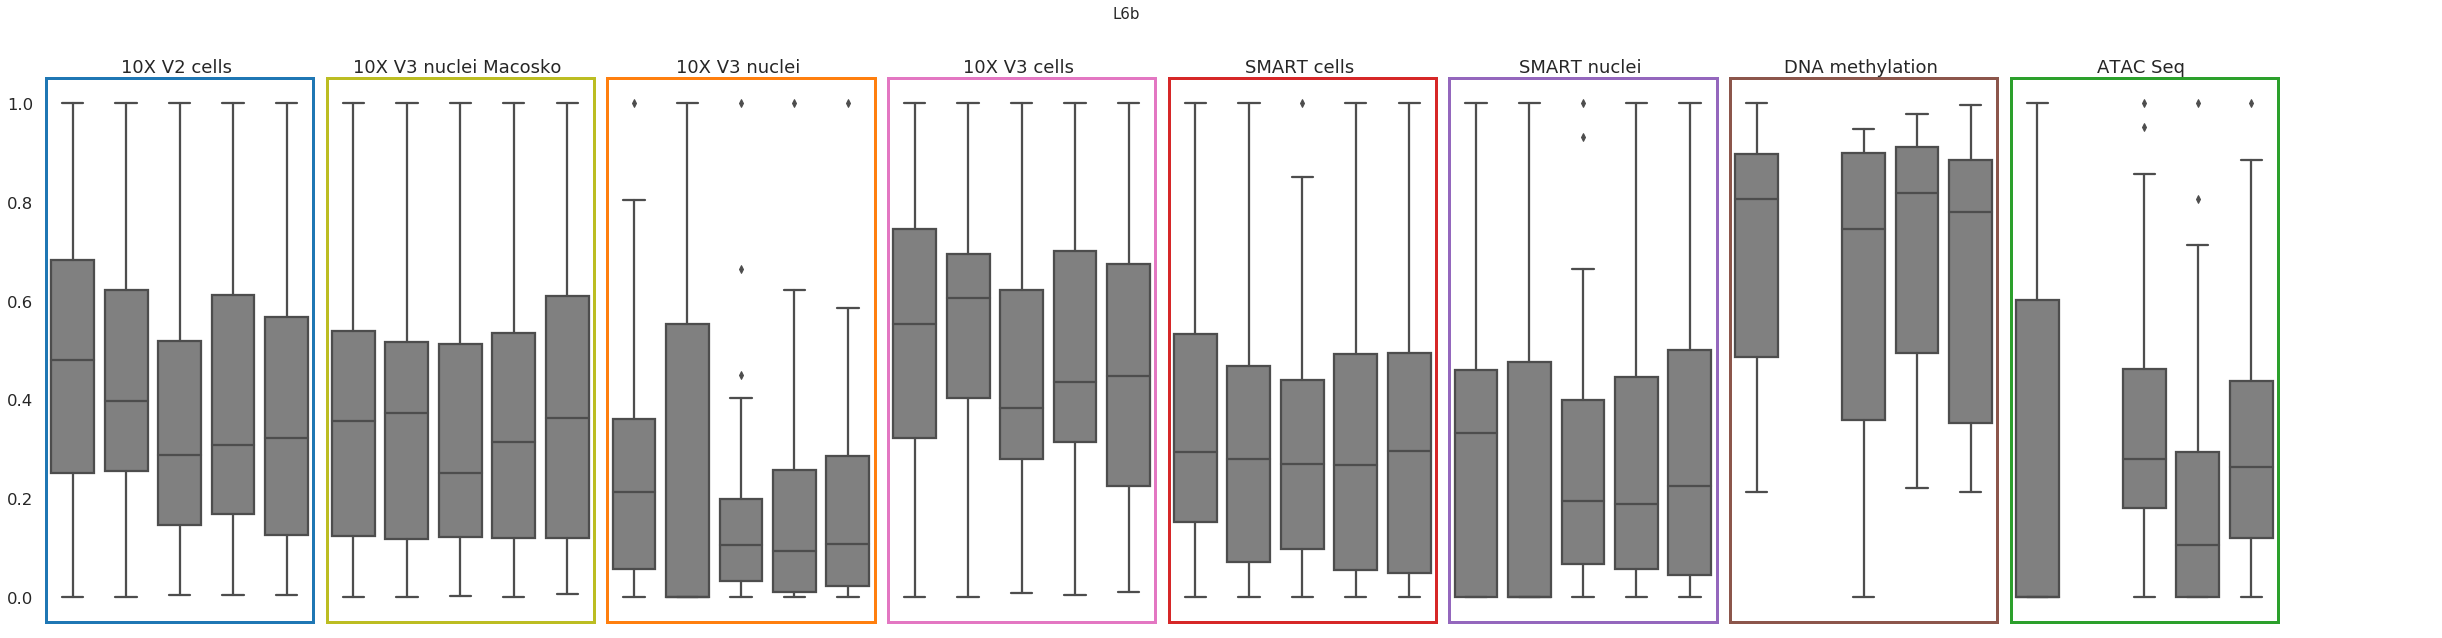

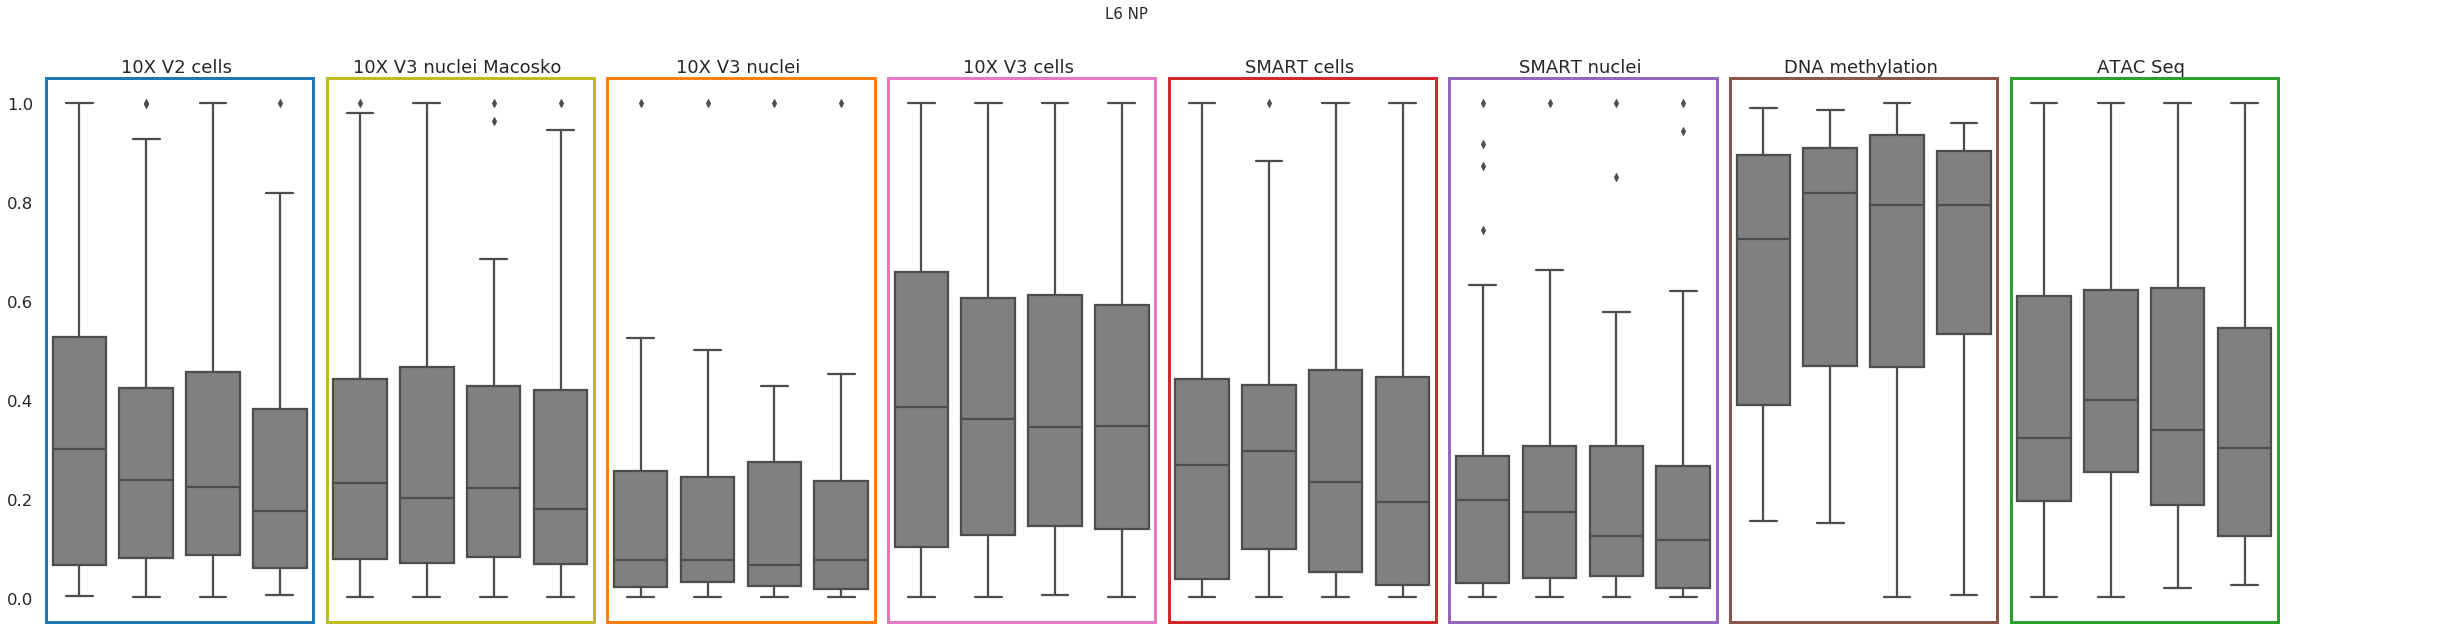

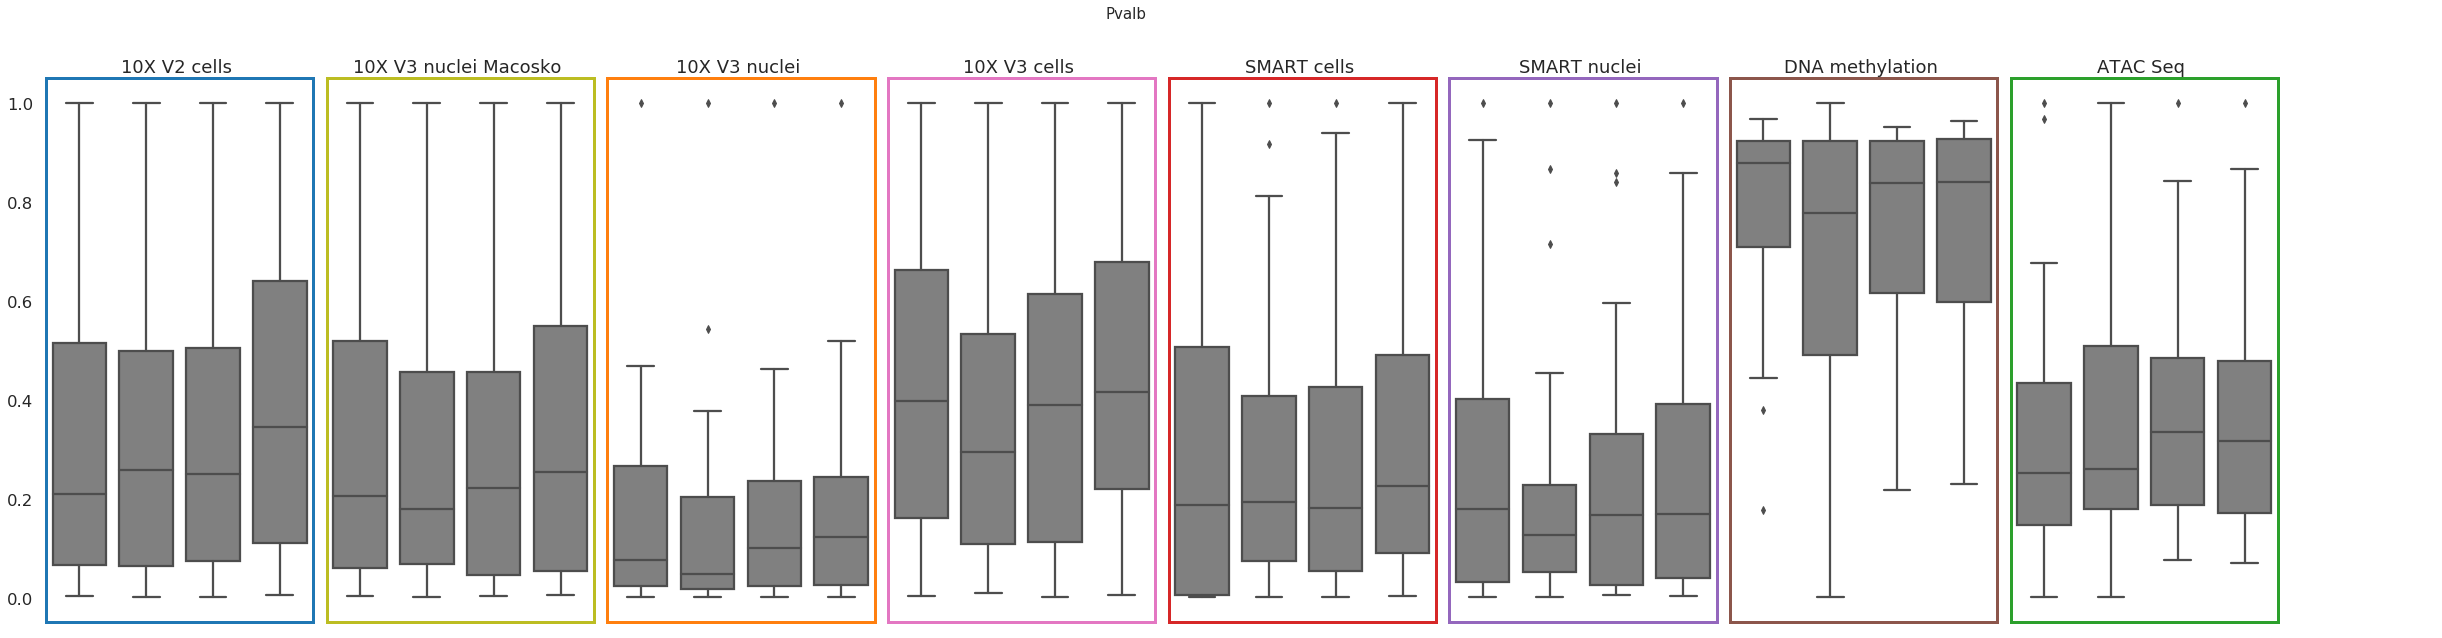

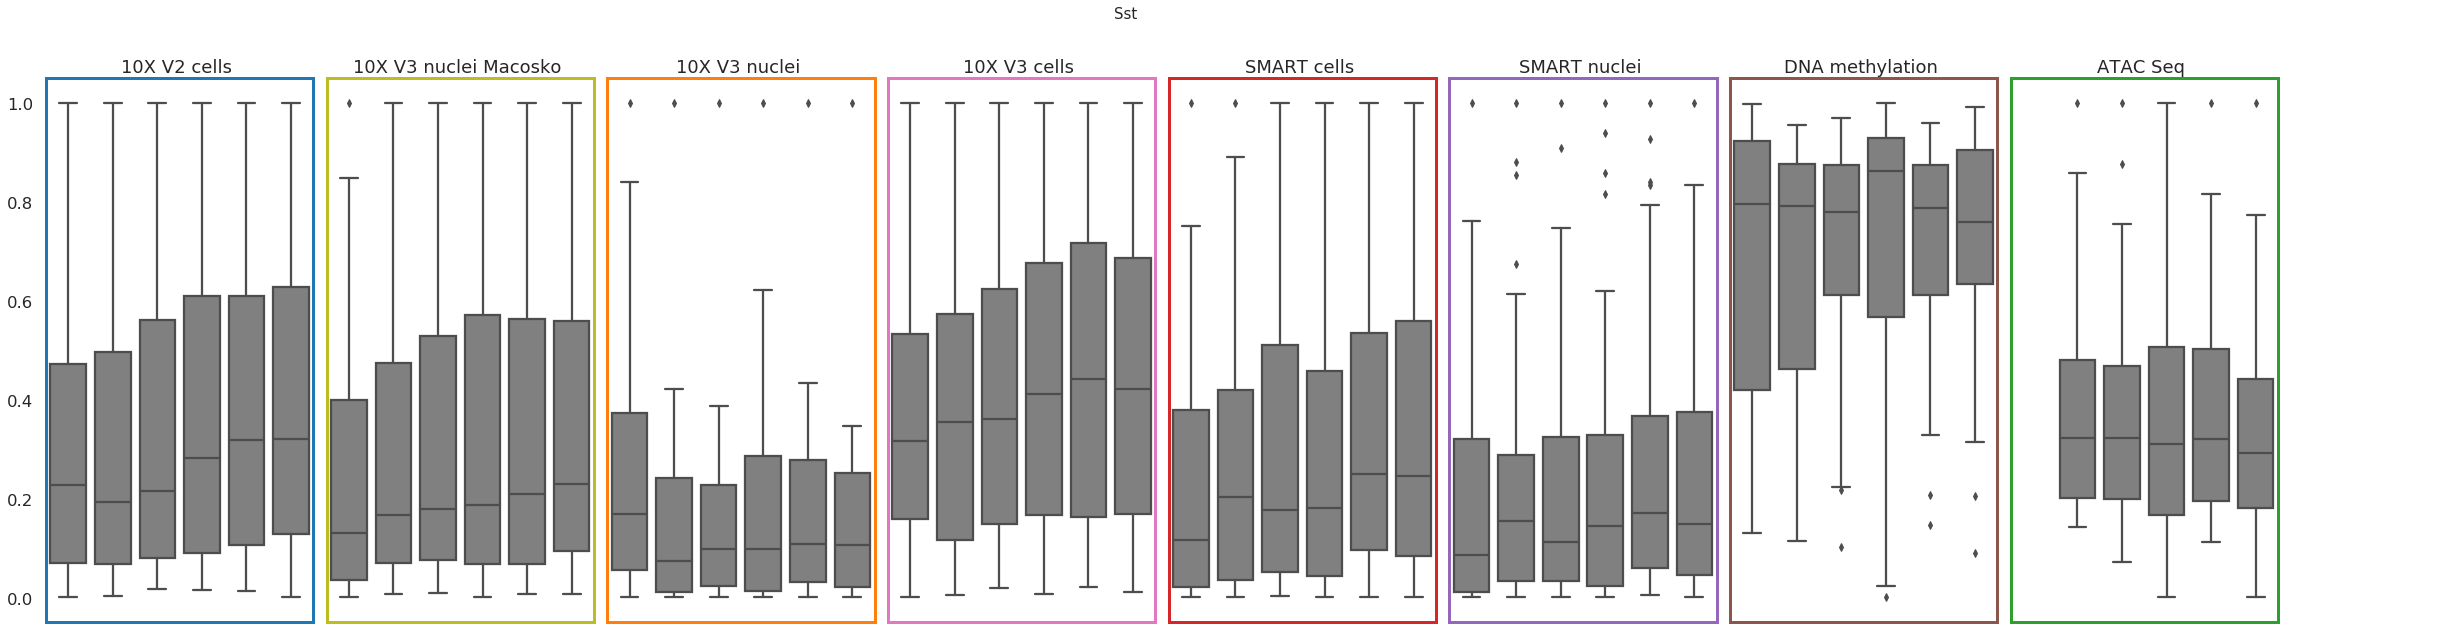

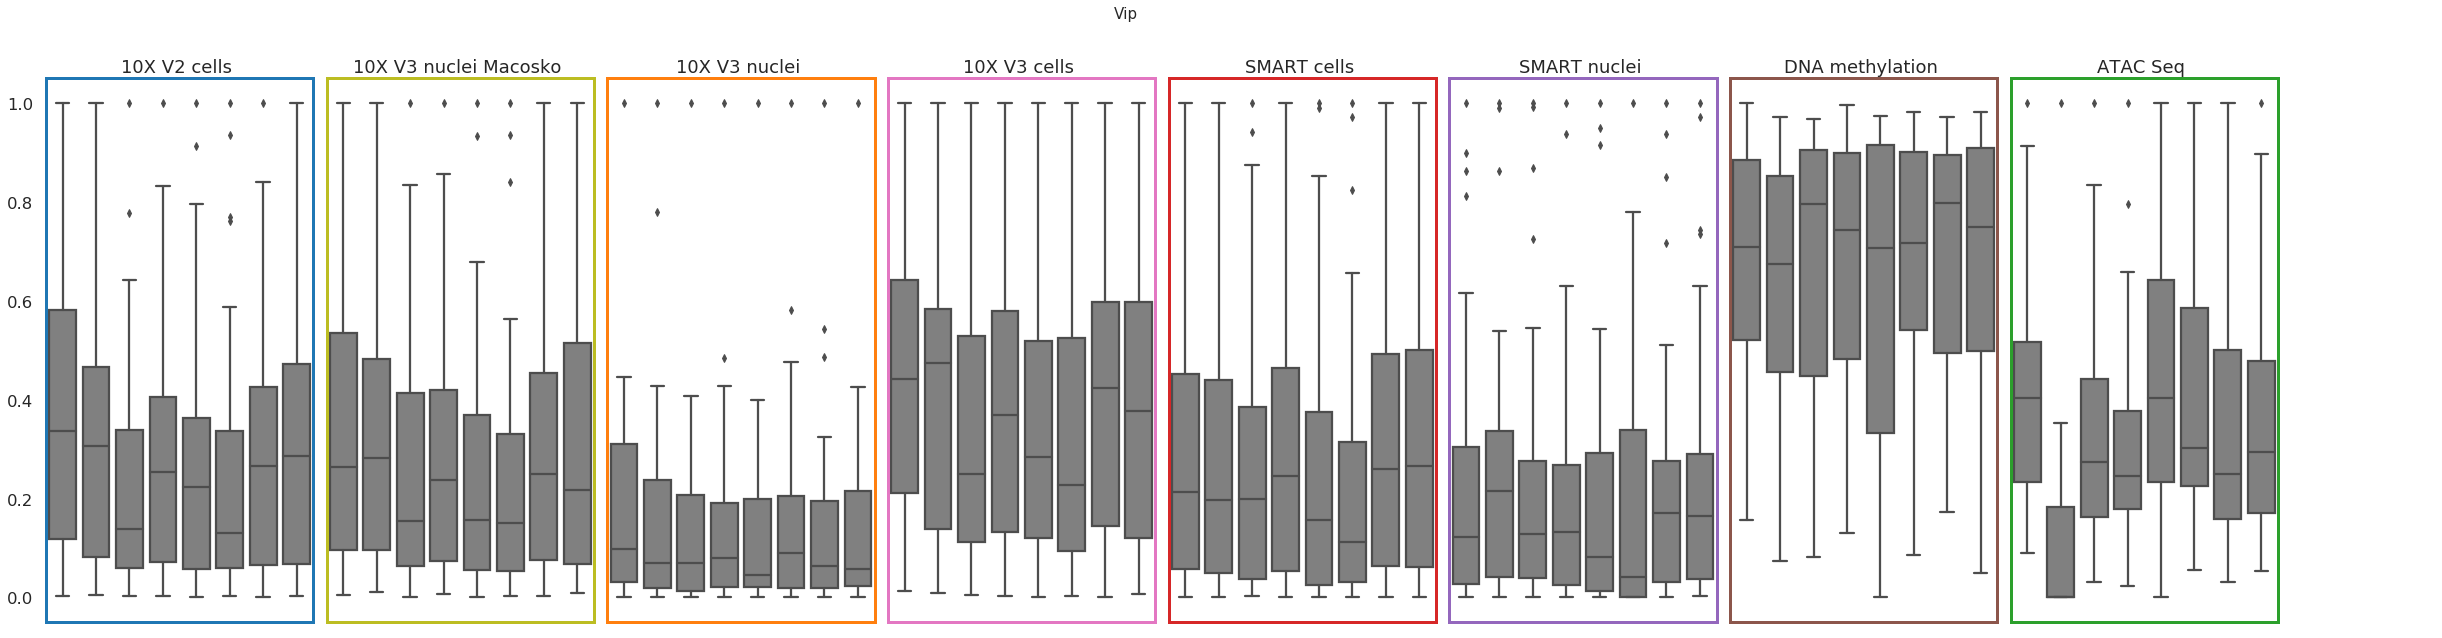

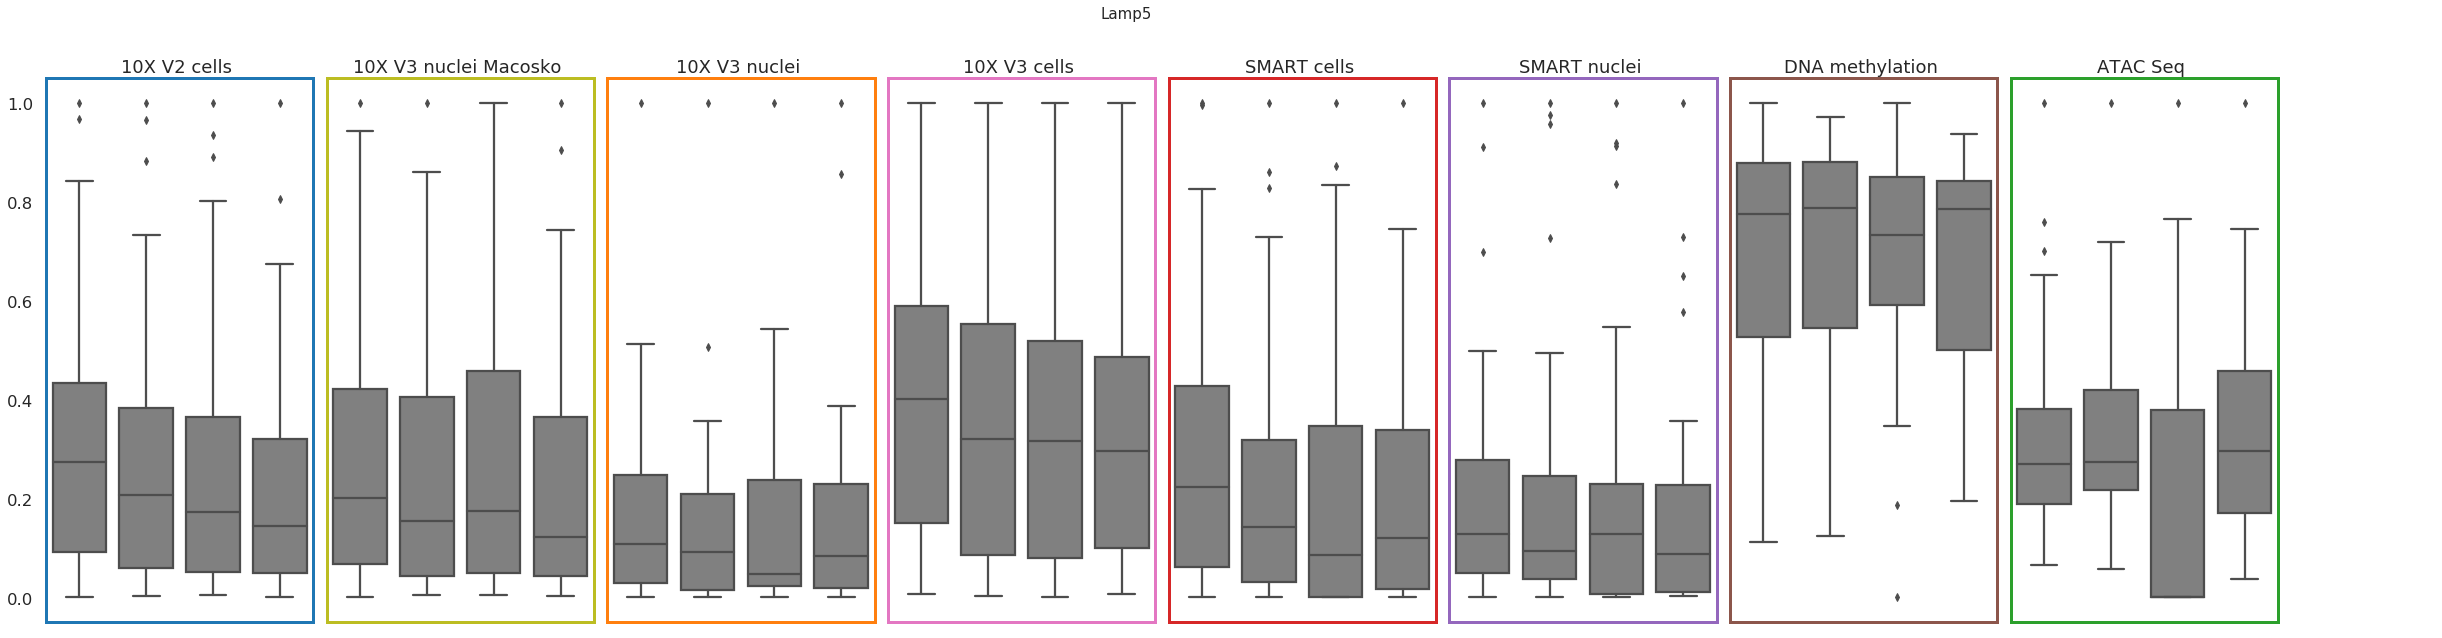

In [95]:
for _class, _clsts_uniq in clsts_uniqs.items():
    with sns.axes_style('white'):
        n = len(mods_ordered)
        nx = 8
        ny = int((n+nx-1)/nx)
        fig, axs = plt.subplots(ny, nx, figsize=(5*nx,10*ny))
        axs = axs.flatten()
        cbar_ax = fig.add_axes([0.9, 0.2, 0.05, 0.6])

        for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
            if i == 0: 
                cbar = False

                # row gene
                Z = sch.linkage(df_plots[mod][_clsts_uniq].fillna(0), method='average', metric='euclidean', optimal_ordering=True)
                dn = sch.dendrogram(Z, no_plot=True)['leaves']
                # col clst
                Z = sch.linkage(df_plots[mod][_clsts_uniq].fillna(0).T, method='average', metric='euclidean', optimal_ordering=True)
                dn_clst = sch.dendrogram(Z, no_plot=True)['leaves']
#             else:
#                 cbar = False

#             if settings[mod].mod_category == 'mc':
#                 vmin, vmax = -1, 0
#             else:
#                 vmin, vmax = 0, 1

            sns.boxplot(data=df_plots[mod][_clsts_uniq].iloc[dn, dn_clst], ax=ax, color='gray')
            ax.set_title('{} '.format(settings[mod].name, ))
            ax.set_xticks([])

#             if i == 0:
#                 ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
#             else:
#                 ax.set_yticks([])
            if i != 0:
                ax.set_yticks([])

            ax.set_xlabel('')

            for _, spine in ax.spines.items():
                spine.set_color(settings[mod].color)
                spine.set_linewidth(3)

        for ax in axs[n:]:
            ax.axis('off')
        cbar_ax.axis('off')


        fig.suptitle(_class, fontsize=15)
        fig.subplots_adjust(hspace=0.05, wspace=0.05)
        fig.savefig(output_figures.format('round3_7_gene_boxplot_IEG_{}'.format(_class.replace(' ', '_').replace('/', '_')), 'pdf'), bbox_inches='tight')
        plt.show()
